In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,balanced_accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_predict,StratifiedGroupKFold,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
#XGBOOST
from xgboost import XGBClassifier
import xgboost
from pygam import GAM, s, f, LogisticGAM
from collections import defaultdict
from sklearn import tree
from scipy.io import loadmat
import json
import optuna
from sklearn.pipeline import Pipeline

Load Unlabeled Data

In [3]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame,mothName):
    #convert dataframe rows into an entire list
    tp = []
    nameArr = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
            nameArr.append(mothName)
    return tp,nameArr

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load xlsx data, extract column with smallest pre_stim
def argMinPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMinColName = df.columns[np.argmin(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMinColName}##########")
    return argMinColName

#load csv data, extract timestamps
def loadData(mothNum):
    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/{mothNum}_spontaneous.csv'

    df = pd.read_csv(loadPath, header = 0)
    
    
    #take samples with stimuli giving largest pre_stim value in first row
    # stimuli = argMinPreStim(mothNum)
    # Df = df.loc[df['stimuli'] == stimuli]
    

    tempDf = []
    tempName = []
    tempNeuron = []
    tempStimuli = []

    neuronCols = list(df.columns[3:])
    stimuli = df['stimuli'][0]
    
    for neuron in neuronCols:
        curArr,nameArr = readData(df[neuron],mothNum)
        tempDf += curArr
        tempName += nameArr
        tempNeuron += [neuron] * len(curArr)
        tempStimuli += [stimuli] * len(curArr)

    #add an entire column of mothNums at the end of tempDf
    #tempDf = np.array(tempDf)
    #mothNums = np.full((tempDf.shape[0],1),mothNum)
    #tempDf = np.concatenate((tempDf,mothNums),axis = 1)
    # print(tempName)

    return tempDf,tempName,tempNeuron,tempStimuli


#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    totalName = []
    totalNeuron = []
    totalStimuli = []
    for mothName in mothNames:
        mothDf,mothNameArr,mothNeuronArr,mothStimuliArr = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
        totalName += mothNameArr
        totalNeuron += mothNeuronArr
        totalStimuli += mothStimuliArr
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf,totalName,totalNeuron,totalStimuli

#GIT data for unsupervised learning
mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf,totalName,totalNeuron,totalStimuli = collectModelData(mothNames)


########current number of rows: 12########
########current number of rows: 7########
########current number of rows: 14########
########current number of rows: 15########
########current number of rows: 16########
########current number of rows: 15########
########current number of rows: 14########
############all data loaded############
############totalDf row number93############


Labeled Data 

In [3]:
# # #pickle the dataframe (which essentially stores the timestamps data)
# # spikeDf.to_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")

# #pickle load spikeDf
# spikeDf = pd.read_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")


# #read labeled_data/verified_LNs.txt file
# verified_LNs = np.loadtxt("/Users/Ocelottamer/Documents/GitHub/AL_generative/labeled_data/verified_LNs.txt",dtype=str)

# #read labeled_data/verified_verified_PNs.xslx file, convert to 
# verified_PNs = pd.read_excel("/Users/Ocelottamer/Documents/GitHub/AL_generative/labeled_data/verified_PNs.xlsx",header=None)
# verified_PNs = list(verified_PNs.iloc[:,0])
# #for each element in verified_PNs, add 0 to front if it has only 8 digits
# for i in range(len(verified_PNs)):
#     if len(str(verified_PNs[i])) == 8:
#         verified_PNs[i] = "0" + str(verified_PNs[i])
#     else:
#         verified_PNs[i] = str(verified_PNs[i])


# #create spike_df, with only verified LNs and verified PNs in spikeDf
# verified_LNs_df = spikeDf[spikeDf['mothname'].isin(verified_LNs)]
# verified_PNs_df = spikeDf[spikeDf['mothname'].isin(verified_PNs)]
# spike_df = pd.concat([verified_LNs_df,verified_PNs_df],axis=0,ignore_index=True)
# #replace label column with 0 for LN and 1 for PN
# spike_df['label'] = spike_df['label'].replace({'LN':0,'PN':1})

# #divide timestamp by 1000 to get seconds
# spike_df['timestamps'] = spike_df['timestamps'].apply(lambda x: x/1000)

# #remind ourselves that this operates on the filtered data
# filtered_df = spike_df

# display(filtered_df)


Derive Nine Parameters

In [4]:
#from timestamp data count average spike frequency (spike count/duration)
def countSpikingFreq(timestamps):
    sum_duration = 0
    spike_count = 0
    for timestamp in timestamps:
        sum_duration += timestamp[-1] - timestamp[0]
        spike_count += len(timestamp)
    return spike_count/sum_duration

#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    # burst /= 1000
    # interBurst /= 1000
    # maxSpikingFreq *= 1000
    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration
    # return num/duration * 1000

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    # meanburstFreq = meanburstFreq* 1000
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]


def formulateDataset(totalDf,totalName = None,totalLabel = None,p = 0.5):
    sampleDataset = []
    nameRes = []
    labelRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_labelRes = []

    if totalName is None:
        totalName = ['']*(totalDf.shape[0])

    if totalLabel is None:
        totalLabel = [0]*(totalDf.shape[0])
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2,p)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            labelRes.append(totalLabel[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_labelRes.append(totalLabel[index])

    return sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes



def formulateDataset_unlabeled(totalDf,totalName = None,totalNeuron = None,totalStimuli = None,p = 0.5):
    sampleDataset = []
    nameRes = []
    neuronRes = []
    stimuliRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_neuronRes = []
    no_burst_stimuliRes = []


    if totalName is None:
        totalName = ['']*(len(totalDf))

    
    if totalNeuron is None:
        totalNeuron = ['']*(len(totalDf))
    
    if totalStimuli is None:
        totalStimuli = ['']*(len(totalDf))
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2,p)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            neuronRes.append(totalNeuron[index])
            stimuliRes.append(totalStimuli[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_neuronRes.append(totalNeuron[index])
            no_burst_stimuliRes.append(totalStimuli[index])

    return sampleDataset,nameRes,neuronRes,stimuliRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes




#unsupervised -- save data into csv file
def saveData(Dataset,nameRes,neuronRes,stimuliRes):
    #load data from csv file
    savePath =  'unsupervised_learning/nine_parameters.csv'

    df = pd.DataFrame(Dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['Neuron'] = neuronRes
    df['Stimuli'] = stimuliRes
    
    # df.to_csv(savePath, index=False)
    return df


#supervised -- save data into csv file
def supervised_saveData(dataset,nameRes,labelRes,save_path = "~/Documents/GitHub/AL_generative/labeled_data/nine_burst_parameters.csv"):
    df = pd.DataFrame(dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['label'] = labelRes
    
    # #save parameters into csv file
    # df.to_csv(save_path, index=False)
    return df

#df = supervised_saveData(sampleDataset,nameRes,labelRes)


#count number of samples for each class in df
def countSamples(df):
    count = defaultdict(int)
    for index,row in df.iterrows():
        count[row['label']] += 1
    return count

#count = countSamples(df)
#print(count)


#define scoring function for later grid search based upon\
    #  AUC, F1 score, and accuracy as evaluation metrics
def evalCriterion(classifier,X,y):
    #prediction labels
    yPred = classifier.predict(X)

    #accuracy
    accu = accuracy_score(y,yPred)

    #F1
    f1 = f1_score(y,yPred)

    #AUC
    #we directly use the labels to compute the AUC scores \
    # (only considering threshold 0.5 while plotting the ROC curve)
    #with the same metric for all classifiers, \
    # we can compare the AUC scores to see which classifier is better
    yPred = classifier.predict_proba(X)[:,1]
    auc = roc_auc_score(y,yPred)
    
    return {'auc':auc,'F1':f1,'accu':accu}

def reductionClassification(sampleDF,lstColumnNames,reductionFunc,reductionParams,\
                            classifyingFunc,classifyingParamsDict,\
                                shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF[lstColumnNames])

    #X and y
    X = sample
    y = sampleDF['label']

    #split into training and test sets
    # X_train,X_test,\
    #     y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

    # fit clustering model with gridsearchCV
    dclf = GridSearchCV(classifyingFunc,classifyingParamsDict,\
                        cv=5,scoring=evalCriterion,\
                            refit='auc',verbose=5,n_jobs=1).fit(X,y).best_estimator_
    
    #predict on whole train set
    # pred_label = dclf.predict(X)

    # #predict on test set
    # pred_label_test = dclf.predict(X_test)

    pred_label = cross_val_predict(dclf,X,y,cv=5)
    
    #calculate AUC, F1 score and accuracy
    pred_AUC = roc_auc_score(y,pred_label)
    pred_F1 = f1_score(y,pred_label)
    pred_accu = accuracy_score(y,pred_label)

    #display
    print('AUC: ',pred_AUC)
    print('F1 score: ',pred_F1)
    print('Accuracy: ',pred_accu)
    
    
    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #put 'Subject' and 'Label' back to reducedSample and form new dataframe
    reducedSampleDF = pd.DataFrame(reducedSample,columns=['PC1','PC2'])
    reducedSampleDF['Subject'] = copy.deepcopy(sampleDF['Subject'])
    reducedSampleDF['label'] = copy.deepcopy(sampleDF['label'])
    reducedSampleDF['pred_label'] = copy.deepcopy(pred_label)

    #give pred_label column also to sampleDF before dimensionality reduction
    sampleDF['pred_label'] = copy.deepcopy(pred_label)
    

    return sampleDF,reducedSampleDF,dclf



def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'compare_histograms.pdf',barplot = False,\
                 figsize = (100,50),main_title = 'Comparison of histograms of 9 parameters',alpha = 0.3):
    #3x3 subplots
    fig,ax = plt.subplots(3,3,figsize=(15,15))
    # fig = plt.figure(figsize=figsize)
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    num = len(lstColumnNames)
    for j in range(num):
        #use "y = " for barplot, "x =  " otherwise
        #figure into the jth subplot
        # fig.add_subplot(num,1,j+1)
        
        if barplot:
            #call barplot function, add a subplot to the 3x3 grid
            plotFunc(data=DF,y=lstColumnNames[j],ax=ax[j//3,j%3],**plotParams)

            
            for bar in ax[j//3,j%3].containers[0]:
                bar.set_alpha(alpha)

        else:
            #call plot function, add a subplot to the 3x3 grid
            plotFunc(data=DF,x=lstColumnNames[j],ax=ax[j//3,j%3],**plotParams)


        
            
    #main title
    fig.suptitle(main_title)

    #save pdf
    fig.savefig(saveFileName)
    plt.show()
    return


Three Rescaled Datasets

In [5]:
display(totalDf)

[array([17.1437, 17.1638, 17.1702, 17.2046, 17.2188, 17.2457, 17.2694,
        17.4844, 17.4965, 17.5062, 17.5543, 17.6392, 17.6652, 17.7928,
        17.8174, 18.8824, 18.9075, 19.2215, 19.2443, 19.2923, 19.696 ,
        19.7037, 19.805 ]),
 array([16.0076, 16.0728, 16.0798, 16.1174, 16.1687, 16.1875, 16.2199,
        16.2785, 16.4193, 16.4347, 16.5062, 16.5185, 16.5305, 16.5346,
        16.5529, 16.7391, 17.0222, 17.0859, 17.1523, 17.2681, 17.2783,
        17.3007, 17.304 , 17.3215, 17.3702, 17.4234, 17.4406, 17.5147,
        17.5316, 17.5449, 17.6216, 17.6361, 17.6947, 17.752 , 17.7748,
        17.7995, 17.8075, 17.9003, 18.701 , 18.7601, 18.8643, 18.9433,
        19.3699, 19.6723]),
 array([19.4153, 19.6343]),
 array([19.4293]),
 array([16.0835, 16.1781, 16.1951, 16.4575, 16.6217, 16.6641, 17.0181,
        17.0251, 17.1247, 17.1419, 17.1899, 17.2221, 17.2852, 17.5057,
        17.6412, 17.6589, 17.6781, 17.8487, 17.8693, 17.9497, 18.1114,
        18.2192, 18.458 , 18.5024, 18.5323, 1

In [6]:
# display(filtered_df)

In [8]:
ts = pd.read_pickle("LNandPN.pkl")
display(ts)

#save dataframe into csv file
# ts.to_csv("LNandPN.csv",index=False)

# ts = pd.DataFrame(pd.read_csv("LNandPN.csv"))
print(ts["timestamps"])

,mothname,timestamps,label
0,ts_LN_CR020108A,"[4.726, 4.8962, 5.0404, 5.2076, 5.3746, 5.5308...",0
1,ts_LN_CR020115A,"[0.16865, 0.37665, 0.58105, 0.70655, 0.7886, 0...",0
2,ts_LN_CR020208A,"[0.4579, 0.7831, 0.89105, 1.5872, 2.0686, 2.88...",0
3,ts_LN_CR020221A,"[0.36345, 0.3944, 0.7277, 0.75125, 10.049, 10....",0
4,ts_LN_CR020225B,"[2.7022, 2.9489, 3.1448, 3.4214, 3.6648, 3.916...",0
...,...,...,...
65,ts_PN_CR040914A,"[0.02805, 0.0454, 0.06255, 0.0809, 0.11385, 0....",1
66,ts_PN_CR040916A,"[0.527, 0.58105, 0.77755, 0.86615, 0.8882, 10....",1
67,ts_PN_CR040920A,"[2.9203, 2.9982, 3.0742, 3.1502, 3.2127, 3.271...",1
68,ts_PN_CR050104A,"[0.0685, 0.12855, 0.16985, 0.22035, 0.2668, 0....",1


0     [4.726, 4.8962, 5.0404, 5.2076, 5.3746, 5.5308...
1     [0.16865, 0.37665, 0.58105, 0.70655, 0.7886, 0...
2     [0.4579, 0.7831, 0.89105, 1.5872, 2.0686, 2.88...
3     [0.36345, 0.3944, 0.7277, 0.75125, 10.049, 10....
4     [2.7022, 2.9489, 3.1448, 3.4214, 3.6648, 3.916...
                            ...                        
65    [0.02805, 0.0454, 0.06255, 0.0809, 0.11385, 0....
66    [0.527, 0.58105, 0.77755, 0.86615, 0.8882, 10....
67    [2.9203, 2.9982, 3.0742, 3.1502, 3.2127, 3.271...
68    [0.0685, 0.12855, 0.16985, 0.22035, 0.2668, 0....
69    [0.05735, 0.0879, 0.14305, 0.325, 0.38835, 0.4...
Name: timestamps, Length: 70, dtype: object


Boxplot for Spiking Frequency

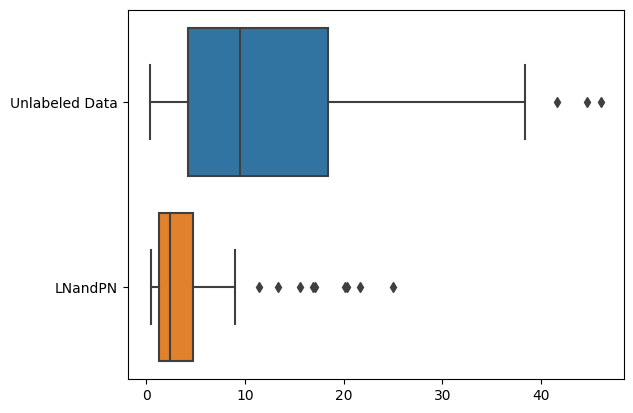

In [9]:
# for index in range(len(totalDf)):
#     print(index)
#     print(countSpikingFreq([totalDf[index]]))

#Unlabeled Data
#plot index,spiking frequency
spikingFreq_unlabeled = []
for index in range(len(totalDf)):
    spikingFreq_unlabeled.append(countSpikingFreq([totalDf[index]]))


# plt.plot(spikingFreq,color='blue')




#LNandPN
# for index,row in LNandPN.iterrows():
#     print(index)
#     print(countSpikingFreq([LNandPN['timestamps'][index]]))

#plot index,spiking frequency
spikingFreq_lnandpn = []
for index,row in ts.iterrows():
    spikingFreq_lnandpn.append(countSpikingFreq([ts['timestamps'][index]]))


# #second labeled data
# spikingFreq_lnpnfiltered = []
# for index,row in spike_df.iterrows():
#     spikingFreq_lnpnfiltered.append(countSpikingFreq([spike_df['timestamps'][index]]))

# spiking_freq = spikingFreq_unlabeled + spikingFreq_lnandpn + spikingFreq_lnpnfiltered
spiking_freq = spikingFreq_unlabeled + spikingFreq_lnandpn
# spiking_freq_labels = ['Unlabeled Data']*len(spikingFreq_unlabeled) + \
#     ['LNandPN']*len(spikingFreq_lnandpn) +\
#         ['LNandPN_filtered']*len(spikingFreq_lnpnfiltered)
spiking_freq_labels = ['Unlabeled Data']*len(spikingFreq_unlabeled) + \
    ['LNandPN']*len(spikingFreq_lnandpn)

sns.boxplot(x = spiking_freq,y=spiking_freq_labels)
# plt.plot(spikingFreq,color='red')
# plt.legend(['Unlabeled Data','LNandPN'])
# plt.xlabel('index')
# plt.ylabel('spiking frequency')
# plt.title('spiking frequency for each sample')

#save figure with size 15,15
plt.savefig('spiking_freq_Feb.jpg',bbox_inches='tight',dpi=300)


plt.show()

Parse through possible p values and compare scales

Unlabeled_0.2    172
PN_0.2            41
LN_0.2            11
Name: label, dtype: int64

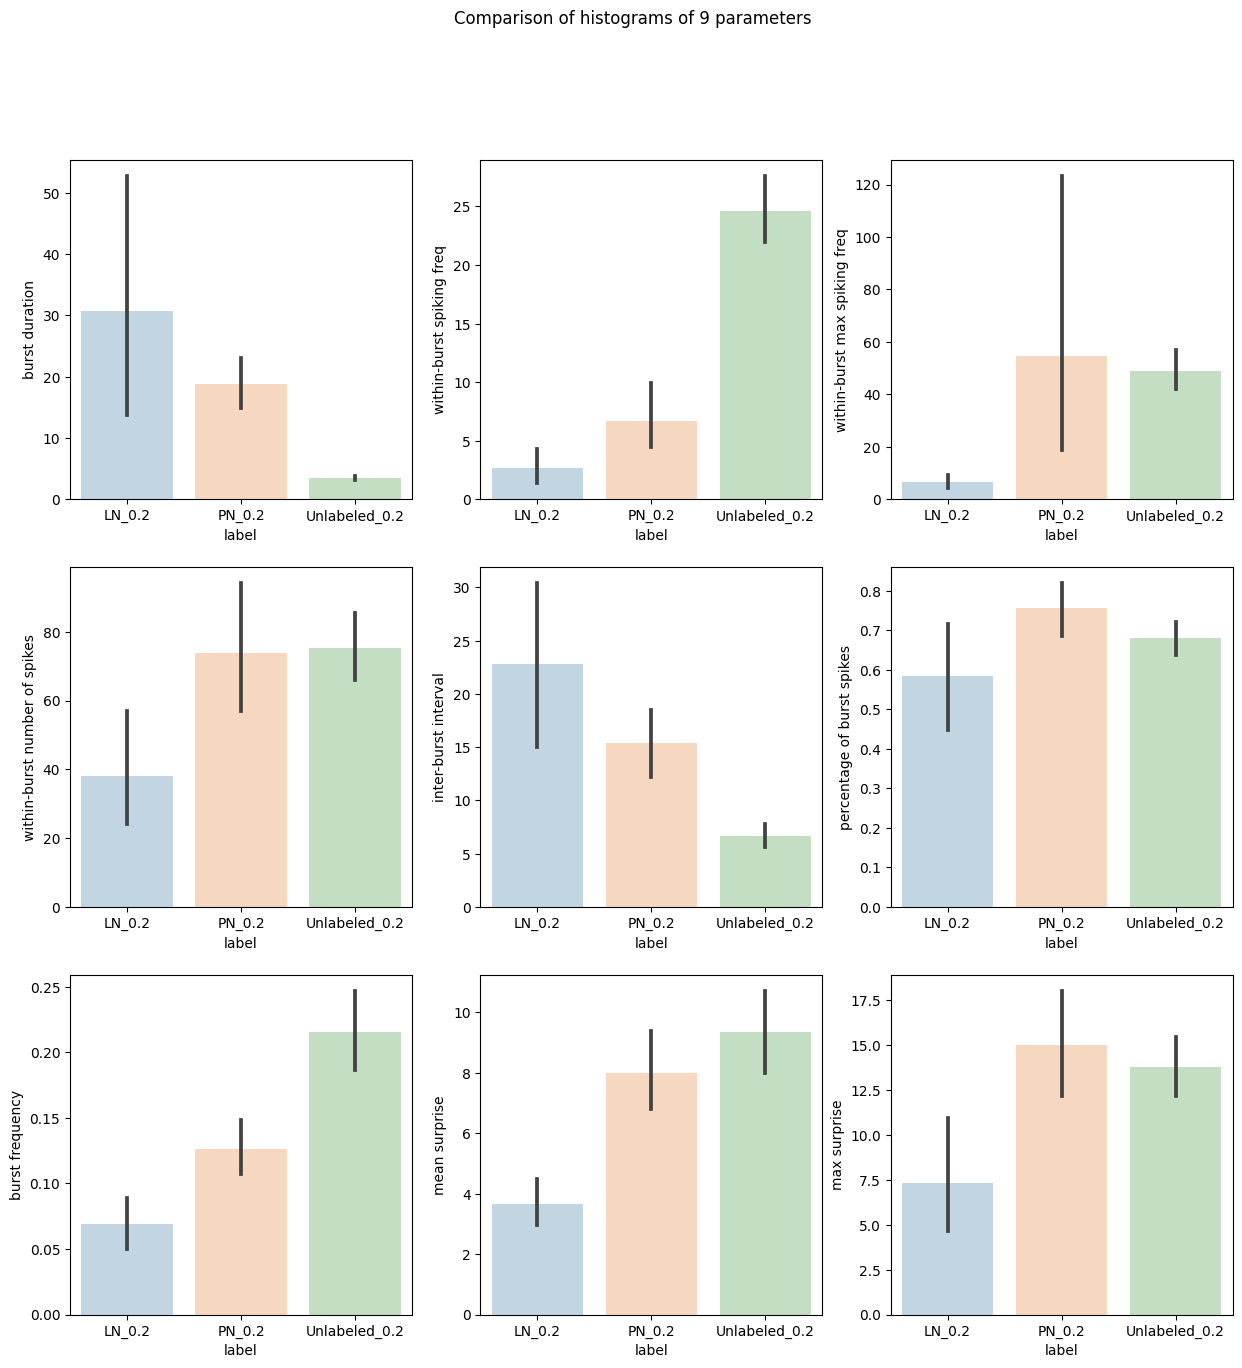

In [10]:
#neglect burst duration, within-burst spiking freq, and inter-burst interval in nine-cols
nine_cols = ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
             'within-burst number of spikes',\
                'inter-burst interval','percentage of burst spikes','burst frequency',\
                'mean surprise','max surprise']



#read LNandPN

res_df = pd.DataFrame(columns = nine_cols + ['label'])

#nine parameters
# for p in np.arange(0.02,0.2,0.02):
for p in [0.2]:
    ts_sampleDataset,ts_nameRes,ts_labelRes,\
        ts_no_burst_sampleDataset,ts_no_burst_nameRes,\
            ts_no_burst_labelRes = formulateDataset(ts['timestamps'],ts['mothname'],ts['label'],p = p)
    ts_df = supervised_saveData(ts_sampleDataset,ts_nameRes,ts_labelRes)

    LN_in_ts_df = ts_df[ts_df['label'] == 0]
    PN_in_ts_df = ts_df[ts_df['label'] == 1]
    LN_in_ts_df = LN_in_ts_df[nine_cols]
    LN_in_ts_df['label'] = f'LN_{p}'

    PN_in_ts_df = PN_in_ts_df[nine_cols]
    PN_in_ts_df['label'] = f'PN_{p}'

    res_df = pd.concat([res_df,LN_in_ts_df,PN_in_ts_df],axis=0,ignore_index=True)

# #filtered labeled data
# for p in [0.5]:
#     label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes,\
#         label_filtered_no_burst_sampleDataset,label_filtered_no_burst_nameRes,\
#             label_filtered_no_burst_labelRes = formulateDataset(spike_df['timestamps'],spike_df['mothname'],spike_df['label'],p = p)
#     label_filtered_df = supervised_saveData(label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes)
    
#     LN_in_label_filtered_df = label_filtered_df[label_filtered_df['label'] == 0]
#     PN_in_label_filtered_df = label_filtered_df[label_filtered_df['label'] == 1]
    
#     LN_in_label_filtered_df = LN_in_label_filtered_df[nine_cols]
#     LN_in_label_filtered_df['label'] = f'filtered_LN_{p}'
#     PN_in_label_filtered_df = PN_in_label_filtered_df[nine_cols]
#     PN_in_label_filtered_df['label'] = f'filtered_PN_{p}'
#     res_df = pd.concat([res_df,LN_in_label_filtered_df,PN_in_label_filtered_df],\
#                        axis=0,ignore_index=True)


#Unlabeled Data concatenated to res_df
# for p in np.arange(0.1,0.5,0.05):
for p in [0.2]:
    unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes,\
            unlabeled_no_burst_sampleDataset,unlabeled_no_burst_nameRes,\
                unlabeled_no_burst_neuronRes,unlabeled_no_burst_stimuliRes,\
                = formulateDataset_unlabeled(totalDf,totalName,totalNeuron,totalStimuli,p)
    unlabeled_df = saveData(unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes)
    unlabeled_df = unlabeled_df[nine_cols]
    unlabeled_df['label'] = f'Unlabeled_{p}'
    res_df = pd.concat([res_df,unlabeled_df],axis=0,ignore_index=True)

#concatenate unlabeled_df to res_df
res_df = pd.concat([res_df,unlabeled_df],axis=0,ignore_index=True)


display(res_df['label'].value_counts())

#barplot of res_df using histogram
histoResults(res_df,nine_cols,sns.barplot,{'x':'label'},\
             barplot = True,saveFileName = 'compare_histograms_LNandPN_Unlabeled_altered_Feb.pdf')

Choose appropriate p values and parameters for each of the three datasets

In [11]:
pruned_nine_cols = ['within-burst max spiking freq',\
                'within-burst number of spikes','percentage of burst spikes','burst frequency',\
                    'mean surprise','max surprise','label']

# pruned_nine_cols = ['within-burst number of spikes','burst frequency',\
#                     'mean surprise','max surprise','label']


#we temporarily make no major changes to filtered_df
# p = 0.5
# label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes,\
#     label_filtered_no_burst_sampleDataset,label_filtered_no_burst_nameRes,\
#         label_filtered_no_burst_labelRes = formulateDataset(filtered_df['timestamps'],filtered_df['mothname'],filtered_df['label'],p)
# label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes,\
#     label_filtered_no_burst_sampleDataset,label_filtered_no_burst_nameRes,\
#         label_filtered_no_burst_labelRes = formulateDataset(filtered_df['timestamps'],filtered_df['mothname'],filtered_df['label'],p)
# label_filtered_df = supervised_saveData(label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes)[pruned_nine_cols]

# print("label_filtered_df")
# display(label_filtered_df)

#feature engineering parameter tuning
p = 0.2
#ts
ts_sampleDataset,ts_nameRes,ts_labelRes,\
    ts_no_burst_sampleDataset,ts_no_burst_nameRes,\
        ts_no_burst_labelRes = formulateDataset(ts['timestamps'],ts['mothname'],ts['label'],p)
ts_df = supervised_saveData(ts_sampleDataset,ts_nameRes,ts_labelRes)
ts_df_pruned = ts_df[pruned_nine_cols]

print("ts_df")
display(ts_df)


#unlabeled
p = 0.2
unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes,\
        unlabeled_no_burst_sampleDataset,unlabeled_no_burst_nameRes,\
            unlabeled_no_burst_neuronRes,unlabeled_no_burst_stimuliRes,\
            = formulateDataset_unlabeled(totalDf,totalName,totalNeuron,totalStimuli,p)
unlabeled_df = saveData(unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes)
#no 'label' column here
unlabeled_df_pruned = unlabeled_df[pruned_nine_cols[:-1]]

print("unlabeled_df_pruned")
display(unlabeled_df_pruned)

print("unlabeled_df")
display(unlabeled_df)



ts_df


,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,21.98430,1.637532,7.455268,36,37.52770,0.782609,0.077377,3.551334,6.606620,ts_LN_CR020108A,0
1,25.77850,1.163760,2.355158,30,14.80760,0.454545,0.027772,3.231017,4.948261,ts_LN_CR020208A,0
2,60.69475,0.939126,15.406162,57,38.75400,0.838235,0.099305,4.617048,12.350901,ts_LN_CR020221A,0
3,3.55200,4.786036,4.786036,17,0.00000,0.226667,0.014138,5.660686,5.660686,ts_LN_CR020225B,0
4,4.78210,5.855168,10.040161,28,28.72320,0.288660,0.046426,2.754773,4.552941,ts_LN_CR020311B,0
5,23.22030,1.335039,5.110733,31,27.35550,0.632653,0.074223,2.645764,4.200363,ts_LN_CR020322A,0
6,3.43300,8.738712,11.235955,30,9.50400,0.483871,0.120744,2.893227,5.188057,ts_LN_CR020327B,0
7,52.06215,2.170483,9.897550,113,38.53230,0.904000,0.099048,6.265610,23.480339,ts_LN_CR020910A,0
8,6.77850,1.180202,1.180202,8,0.00000,0.285714,0.040466,4.186473,4.186473,ts_LN_CR030618A,0
9,12.58655,1.032849,3.510620,13,27.34460,0.650000,0.073203,2.261379,2.934738,ts_LN_CR030710A,0


unlabeled_df_pruned


,within-burst max spiking freq,within-burst number of spikes,percentage of burst spikes,burst frequency,mean surprise,max surprise
0,21.568325,20,0.909091,0.100985,8.129553,13.005666
1,20.556698,37,0.860465,0.050833,22.067839,22.067839
2,10.524895,39,1.000000,0.050041,15.146894,15.146894
3,93.750000,13,1.000000,0.154292,6.023302,7.575765
4,2.875216,4,0.800000,0.050921,2.753871,2.753871
...,...,...,...,...,...,...
81,15.313936,39,0.750000,0.200954,4.030531,8.179410
82,70.422535,23,0.460000,0.255294,2.609333,3.521100
83,20.990764,50,0.769231,0.250262,3.750014,9.769924
84,233.918129,270,0.437601,0.950062,3.861261,18.424534


unlabeled_df


,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Neuron,Stimuli
0,1.4453,13.837958,21.568325,20,1.1147,0.909091,0.100985,8.129553,13.005666,070906,S1U1,Lin
1,1.7999,20.556698,20.556698,37,0.0000,0.860465,0.050833,22.067839,22.067839,070906,S2U1,Lin
2,3.7055,10.524895,10.524895,39,0.0000,1.000000,0.050041,15.146894,15.146894,070906,S2U4,Lin
3,3.0363,4.281527,93.750000,13,0.0428,1.000000,0.154292,6.023302,7.575765,070906,S2U5,Lin
4,1.3912,2.875216,2.875216,4,0.0000,0.800000,0.050921,2.753871,2.753871,070906,S3U1,Lin
...,...,...,...,...,...,...,...,...,...,...,...,...
81,13.4148,2.907237,15.313936,39,3.0775,0.750000,0.200954,4.030531,8.179410,071002,S1U1_selectiveunit,Myr
82,2.6058,8.826464,70.422535,23,15.0734,0.460000,0.255294,2.609333,3.521100,071002,S1U2,Myr
83,4.4924,11.129908,20.990764,50,12.9673,0.769231,0.250262,3.750014,9.769924,071002,S1U3,Myr
84,2.6336,102.521264,233.918129,270,15.3836,0.437601,0.950062,3.861261,18.424534,071002,S1U4,Myr


In [11]:
sns.set(font_scale=1)


Logistic Regression (Bayesian Optimization)

In [12]:
def get_label_from_true_json(data,name_base,neuron_base,true_json_data):
    true_label = []

    for i,label in enumerate(data):
        true_label.append(true_json_data[name_base[i]][neuron_base[i]]['true'])


    return true_label

true_json_data = json.load(open('unlabeled_pred.json'))



def lr_objective(trial):
    #lr parameters
    solver = trial.suggest_categorical('solver',['newton-cg','lbfgs','liblinear','sag','saga'])
    C = trial.suggest_loguniform('C',1e-5,1e2)
    tol = trial.suggest_loguniform('tol',1e-5,1e-1)

    #scaler
    scaler_label = trial.suggest_categorical('scaler',['standard','minmax'])
    if scaler_label == 'standard':
        scaler = preprocessing.StandardScaler()
    else:
        scaler = preprocessing.MinMaxScaler()

    #choice of 9 columns
    prune = trial.suggest_categorical('prune',['yes','no'])
    if prune == 'yes':
        pruned_nine_cols = ['within-burst max spiking freq',\
                    'within-burst number of spikes','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise','label']
    else:
        pruned_nine_cols = ['within-burst number of spikes','burst frequency',\
                            'mean surprise','max surprise','label']

    #p parameter
    p_labeled = trial.suggest_float('p_labeled',0.1,0.9)
    p_unlabeled = trial.suggest_float('p_unlabeled',0.1,0.9)

    #exploratory data analysis
    print(f"#######Start Burst Detection, trial: {trial.number}#######")
    #ts
    ts_sampleDataset,ts_nameRes,ts_labelRes,\
        ts_no_burst_sampleDataset,ts_no_burst_nameRes,\
            ts_no_burst_labelRes = formulateDataset(ts['timestamps'],ts['mothname'],ts['label'],p = p_labeled)
    ts_df = supervised_saveData(ts_sampleDataset,ts_nameRes,ts_labelRes)
    ts_df_pruned = ts_df[pruned_nine_cols]

    #unlabeled
    unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes,\
            unlabeled_no_burst_sampleDataset,unlabeled_no_burst_nameRes,\
                unlabeled_no_burst_neuronRes,unlabeled_no_burst_stimuliRes,\
                = formulateDataset_unlabeled(totalDf,totalName,totalNeuron,totalStimuli,p = p_unlabeled)
    unlabeled_df = saveData(unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes)
    #no 'label' column here, so we add :-1
    unlabeled_df_pruned = unlabeled_df[pruned_nine_cols[:-1]]

    #take every fold as a test set and the rest as training set, setup scaler w.r.t. training set
    #preprocessing with scaler on ts data 
    ts_df_pruned_processed = scaler.fit_transform(ts_df_pruned.iloc[:,:-1])

    print(f"#######Burst Detection Finished, trial: {trial.number}#######")

    print(f"#######Start Logistic Regression, trial: {trial.number}#######")


    lr = LogisticRegression(solver = solver,C = C,tol = tol)

    #fit the model
    #display number of columns of ts_df_pruned_processed
    # print(f"#######Number of columns of ts_df_pruned_processed: {ts_df_pruned_processed.shape[1]}#######")
    lr.fit(ts_df_pruned_processed,ts_df_pruned['label'])

    #preprocessing with scaler on unlabeled data
    unlabeled_df_pruned_processed = scaler.fit_transform(unlabeled_df_pruned)
    #display number of columns of unlabeled_df_pruned_processed
    # print(f"#######Number of columns of unlabeled_df_pruned_processed: {unlabeled_df_pruned_processed.shape[1]}#######")
    print(f"#######Logistic Regression Finished, trial: {trial.number}#######")


    #predict on test set
    print(f"#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: {trial.number}#######")
    pred_label = lr.predict(unlabeled_df_pruned_processed)


    true_labels = get_label_from_true_json(pred_label,unlabeled_nameRes,unlabeled_neuronRes,true_json_data)
    true_labels_no_burst = get_label_from_true_json(unlabeled_no_burst_nameRes,unlabeled_no_burst_nameRes,unlabeled_no_burst_neuronRes,true_json_data)
    true_labels_extended = true_labels + true_labels_no_burst
    #replace 0 in pred_label as 'LN' and 1 as 'PN'
    pred_label = list(map(lambda x: 'LN' if x == 0 else 'PN',pred_label))
    #append LNs after predicted labels
    unlabeled_pred_extended = list(pred_label + ['LN']*len(unlabeled_no_burst_nameRes))

    #compute accuracy
    pred_accu = accuracy_score(true_labels_extended,unlabeled_pred_extended)
    print(f"#######Output Accuracy: {pred_accu}, trial: {trial.number}#######")

    return pred_accu


study = optuna.create_study(direction='maximize')
study.optimize(lr_objective,n_trials=100)

display(study.best_params,study.best_value)

[I 2024-03-11 12:52:10,137] A new study created in memory with name: no-name-0c0ed61b-7a21-49c1-aceb-6e1f07e89530


#######Start Burst Detection, trial: 0#######


[I 2024-03-11 12:52:35,610] Trial 0 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 0.00816672968158166, 'tol': 0.0004897529195159634, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.18178909067684623, 'p_unlabeled': 0.2942361299735591}. Best is trial 0 with value: 0.6344086021505376.


#######Burst Detection Finished, trial: 0#######
#######Start Logistic Regression, trial: 0#######
#######Logistic Regression Finished, trial: 0#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 0#######
#######Output Accuracy: 0.6344086021505376, trial: 0#######
#######Start Burst Detection, trial: 1#######


[I 2024-03-11 12:53:05,099] Trial 1 finished with value: 0.6236559139784946 and parameters: {'solver': 'liblinear', 'C': 0.0005020974699112642, 'tol': 0.00016410533869908966, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.11451590580087379, 'p_unlabeled': 0.6785836145322287}. Best is trial 0 with value: 0.6344086021505376.


#######Burst Detection Finished, trial: 1#######
#######Start Logistic Regression, trial: 1#######
#######Logistic Regression Finished, trial: 1#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 1#######
#######Output Accuracy: 0.6236559139784946, trial: 1#######
#######Start Burst Detection, trial: 2#######


[I 2024-03-11 12:53:52,746] Trial 2 finished with value: 0.6236559139784946 and parameters: {'solver': 'saga', 'C': 7.082640917531549e-05, 'tol': 0.0007421918397091687, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.5055195160427296, 'p_unlabeled': 0.7635160281097696}. Best is trial 0 with value: 0.6344086021505376.


#######Burst Detection Finished, trial: 2#######
#######Start Logistic Regression, trial: 2#######
#######Logistic Regression Finished, trial: 2#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 2#######
#######Output Accuracy: 0.6236559139784946, trial: 2#######
#######Start Burst Detection, trial: 3#######


[I 2024-03-11 12:54:33,257] Trial 3 finished with value: 0.5591397849462365 and parameters: {'solver': 'sag', 'C': 21.041176402775573, 'tol': 0.011506175179417964, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.49580731001558387, 'p_unlabeled': 0.6892267707000229}. Best is trial 0 with value: 0.6344086021505376.


#######Burst Detection Finished, trial: 3#######
#######Start Logistic Regression, trial: 3#######
#######Logistic Regression Finished, trial: 3#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 3#######
#######Output Accuracy: 0.5591397849462365, trial: 3#######
#######Start Burst Detection, trial: 4#######


[I 2024-03-11 12:55:14,882] Trial 4 finished with value: 0.44086021505376344 and parameters: {'solver': 'newton-cg', 'C': 66.33042744472078, 'tol': 2.7510766009021336e-05, 'scaler': 'minmax', 'prune': 'no', 'p_labeled': 0.6730259014721042, 'p_unlabeled': 0.6856189604089875}. Best is trial 0 with value: 0.6344086021505376.


#######Burst Detection Finished, trial: 4#######
#######Start Logistic Regression, trial: 4#######
#######Logistic Regression Finished, trial: 4#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 4#######
#######Output Accuracy: 0.44086021505376344, trial: 4#######
#######Start Burst Detection, trial: 5#######


[I 2024-03-11 12:55:58,026] Trial 5 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 72.25431421199977, 'tol': 9.678212822679224e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.7445194101707656, 'p_unlabeled': 0.633194838866346}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 5#######
#######Start Logistic Regression, trial: 5#######
#######Logistic Regression Finished, trial: 5#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 5#######
#######Output Accuracy: 0.6451612903225806, trial: 5#######
#######Start Burst Detection, trial: 6#######


[I 2024-03-11 12:56:33,427] Trial 6 finished with value: 0.6236559139784946 and parameters: {'solver': 'newton-cg', 'C': 0.0178368561520234, 'tol': 1.1042782621193033e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.8212965643611948, 'p_unlabeled': 0.3739096702513681}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 6#######
#######Start Logistic Regression, trial: 6#######
#######Logistic Regression Finished, trial: 6#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 6#######
#######Output Accuracy: 0.6236559139784946, trial: 6#######
#######Start Burst Detection, trial: 7#######


[I 2024-03-11 12:57:12,293] Trial 7 finished with value: 0.6236559139784946 and parameters: {'solver': 'sag', 'C': 0.0005676449805928404, 'tol': 3.554389875877732e-05, 'scaler': 'minmax', 'prune': 'no', 'p_labeled': 0.6465636885660992, 'p_unlabeled': 0.6013644809273047}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 7#######
#######Start Logistic Regression, trial: 7#######
#######Logistic Regression Finished, trial: 7#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 7#######
#######Output Accuracy: 0.6236559139784946, trial: 7#######
#######Start Burst Detection, trial: 8#######


[I 2024-03-11 12:57:58,065] Trial 8 finished with value: 0.6236559139784946 and parameters: {'solver': 'liblinear', 'C': 0.0007169449993137995, 'tol': 0.0010873070821229725, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.7702966647567288, 'p_unlabeled': 0.8128633301017936}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 8#######
#######Start Logistic Regression, trial: 8#######
#######Logistic Regression Finished, trial: 8#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 8#######
#######Output Accuracy: 0.6236559139784946, trial: 8#######
#######Start Burst Detection, trial: 9#######


[I 2024-03-11 12:58:27,072] Trial 9 finished with value: 0.6344086021505376 and parameters: {'solver': 'sag', 'C': 0.0273946531289608, 'tol': 0.08232545739061099, 'scaler': 'minmax', 'prune': 'no', 'p_labeled': 0.7033611846041129, 'p_unlabeled': 0.18365646348779469}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 9#######
#######Start Logistic Regression, trial: 9#######
#######Logistic Regression Finished, trial: 9#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 9#######
#######Output Accuracy: 0.6344086021505376, trial: 9#######
#######Start Burst Detection, trial: 10#######


[I 2024-03-11 12:59:05,429] Trial 10 finished with value: 0.5913978494623656 and parameters: {'solver': 'lbfgs', 'C': 1.8341557566604845, 'tol': 7.301041624420751e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.8884498074435963, 'p_unlabeled': 0.882980456743361}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 10#######
#######Start Logistic Regression, trial: 10#######
#######Logistic Regression Finished, trial: 10#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 10#######
#######Output Accuracy: 0.5913978494623656, trial: 10#######
#######Start Burst Detection, trial: 11#######


[I 2024-03-11 12:59:32,656] Trial 11 finished with value: 0.6236559139784946 and parameters: {'solver': 'lbfgs', 'C': 0.6231198192254584, 'tol': 0.00027491800410976583, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.11566997457588826, 'p_unlabeled': 0.44684262190458435}. Best is trial 5 with value: 0.6451612903225806.


#######Burst Detection Finished, trial: 11#######
#######Start Logistic Regression, trial: 11#######
#######Logistic Regression Finished, trial: 11#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 11#######
#######Output Accuracy: 0.6236559139784946, trial: 11#######
#######Start Burst Detection, trial: 12#######


[I 2024-03-11 13:00:17,135] Trial 12 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 0.8686170251519965, 'tol': 0.0008360114450636142, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.27608302138966606, 'p_unlabeled': 0.33301247048653215}. Best is trial 12 with value: 0.6559139784946236.


#######Burst Detection Finished, trial: 12#######
#######Start Logistic Regression, trial: 12#######
#######Logistic Regression Finished, trial: 12#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 12#######
#######Output Accuracy: 0.6559139784946236, trial: 12#######
#######Start Burst Detection, trial: 13#######


[I 2024-03-11 13:01:08,509] Trial 13 finished with value: 0.6129032258064516 and parameters: {'solver': 'lbfgs', 'C': 5.4294469468989135, 'tol': 0.002457000027970001, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3038846821724163, 'p_unlabeled': 0.5426146083688109}. Best is trial 12 with value: 0.6559139784946236.


#######Burst Detection Finished, trial: 13#######
#######Start Logistic Regression, trial: 13#######
#######Logistic Regression Finished, trial: 13#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 13#######
#######Output Accuracy: 0.6129032258064516, trial: 13#######
#######Start Burst Detection, trial: 14#######


[I 2024-03-11 13:01:46,504] Trial 14 finished with value: 0.7096774193548387 and parameters: {'solver': 'lbfgs', 'C': 95.6735507689309, 'tol': 7.71749437012962e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.35590666199140963, 'p_unlabeled': 0.46671749552391184}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 14#######
#######Start Logistic Regression, trial: 14#######
#######Logistic Regression Finished, trial: 14#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 14#######
#######Output Accuracy: 0.7096774193548387, trial: 14#######
#######Start Burst Detection, trial: 15#######


[I 2024-03-11 13:02:24,638] Trial 15 finished with value: 0.6344086021505376 and parameters: {'solver': 'saga', 'C': 0.5512952725929058, 'tol': 0.002257936654845822, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.29892672960000133, 'p_unlabeled': 0.4522074779730457}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 15#######
#######Start Logistic Regression, trial: 15#######
#######Logistic Regression Finished, trial: 15#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 15#######
#######Output Accuracy: 0.6344086021505376, trial: 15#######
#######Start Burst Detection, trial: 16#######


[I 2024-03-11 13:03:05,738] Trial 16 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 0.23383219665818736, 'tol': 0.00024697239385909435, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.34265082520691786, 'p_unlabeled': 0.2845626718069436}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 16#######
#######Start Logistic Regression, trial: 16#######
#######Logistic Regression Finished, trial: 16#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 16#######
#######Output Accuracy: 0.6344086021505376, trial: 16#######
#######Start Burst Detection, trial: 17#######


[I 2024-03-11 13:03:25,058] Trial 17 finished with value: 0.6881720430107527 and parameters: {'solver': 'lbfgs', 'C': 8.13504290478851, 'tol': 7.616280350737997e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3893722975020202, 'p_unlabeled': 0.10080322494979549}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 17#######
#######Start Logistic Regression, trial: 17#######
#######Logistic Regression Finished, trial: 17#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 17#######
#######Output Accuracy: 0.6881720430107527, trial: 17#######
#######Start Burst Detection, trial: 18#######


[I 2024-03-11 13:03:46,815] Trial 18 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 15.128952147720495, 'tol': 5.576622646723813e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.41606877828568734, 'p_unlabeled': 0.10747820108494088}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 18#######
#######Start Logistic Regression, trial: 18#######
#######Logistic Regression Finished, trial: 18#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 18#######
#######Output Accuracy: 0.6559139784946236, trial: 18#######
#######Start Burst Detection, trial: 19#######


[I 2024-03-11 13:04:20,224] Trial 19 finished with value: 0.6451612903225806 and parameters: {'solver': 'newton-cg', 'C': 9.944188150998938, 'tol': 1.484429686154355e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.5662367221230772, 'p_unlabeled': 0.1728936080316399}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 19#######
#######Start Logistic Regression, trial: 19#######
#######Logistic Regression Finished, trial: 19#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 19#######
#######Output Accuracy: 0.6451612903225806, trial: 19#######
#######Start Burst Detection, trial: 20#######


[I 2024-03-11 13:04:53,006] Trial 20 finished with value: 0.5161290322580645 and parameters: {'solver': 'saga', 'C': 80.54812828464802, 'tol': 0.00012099583581759286, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.40115390649827787, 'p_unlabeled': 0.5054666073798302}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 20#######
#######Start Logistic Regression, trial: 20#######
#######Logistic Regression Finished, trial: 20#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 20#######
#######Output Accuracy: 0.5161290322580645, trial: 20#######
#######Start Burst Detection, trial: 21#######


[I 2024-03-11 13:05:24,108] Trial 21 finished with value: 0.6236559139784946 and parameters: {'solver': 'lbfgs', 'C': 5.712953539179806, 'tol': 3.232908401505318e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.2215435863278346, 'p_unlabeled': 0.3555929463525132}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 21#######
#######Start Logistic Regression, trial: 21#######
#######Logistic Regression Finished, trial: 21#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 21#######
#######Output Accuracy: 0.6236559139784946, trial: 21#######
#######Start Burst Detection, trial: 22#######


[I 2024-03-11 13:05:57,137] Trial 22 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 2.215581175274618, 'tol': 0.0002783513535638578, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.2551400293816687, 'p_unlabeled': 0.22020486858746038}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 22#######
#######Start Logistic Regression, trial: 22#######
#######Logistic Regression Finished, trial: 22#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 22#######
#######Output Accuracy: 0.6344086021505376, trial: 22#######
#######Start Burst Detection, trial: 23#######


[I 2024-03-11 13:06:21,925] Trial 23 finished with value: 0.6666666666666666 and parameters: {'solver': 'lbfgs', 'C': 0.13509761367971854, 'tol': 8.71764771415973e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.37411033616155925, 'p_unlabeled': 0.11297955295337606}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 23#######
#######Start Logistic Regression, trial: 23#######
#######Logistic Regression Finished, trial: 23#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 23#######
#######Output Accuracy: 0.6666666666666666, trial: 23#######
#######Start Burst Detection, trial: 24#######


[I 2024-03-11 13:06:39,985] Trial 24 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.07181029772823709, 'tol': 6.98083388058647e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3728409131125605, 'p_unlabeled': 0.11487898773463738}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 24#######
#######Start Logistic Regression, trial: 24#######
#######Logistic Regression Finished, trial: 24#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 24#######
#######Output Accuracy: 0.6774193548387096, trial: 24#######
#######Start Burst Detection, trial: 25#######


[I 2024-03-11 13:07:05,799] Trial 25 finished with value: 0.6344086021505376 and parameters: {'solver': 'liblinear', 'C': 0.10354896366317491, 'tol': 2.058301167781094e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4298466276605725, 'p_unlabeled': 0.22945793681038598}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 25#######
#######Start Logistic Regression, trial: 25#######
#######Logistic Regression Finished, trial: 25#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 25#######
#######Output Accuracy: 0.6344086021505376, trial: 25#######
#######Start Burst Detection, trial: 26#######


[I 2024-03-11 13:07:27,348] Trial 26 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 23.11314900408178, 'tol': 3.8659637455589084e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.3250258490807716, 'p_unlabeled': 0.14772468059393654}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 26#######
#######Start Logistic Regression, trial: 26#######
#######Logistic Regression Finished, trial: 26#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 26#######
#######Output Accuracy: 0.6451612903225806, trial: 26#######
#######Start Burst Detection, trial: 27#######


[I 2024-03-11 13:08:10,952] Trial 27 finished with value: 0.6236559139784946 and parameters: {'solver': 'lbfgs', 'C': 4.056707347222607, 'tol': 1.1354585908369117e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.357195048107644, 'p_unlabeled': 0.23874747853240552}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 27#######
#######Start Logistic Regression, trial: 27#######
#######Logistic Regression Finished, trial: 27#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 27#######
#######Output Accuracy: 0.6236559139784946, trial: 27#######
#######Start Burst Detection, trial: 28#######


[I 2024-03-11 13:08:39,524] Trial 28 finished with value: 0.6881720430107527 and parameters: {'solver': 'lbfgs', 'C': 1.8119825147154156, 'tol': 4.4227375341041656e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4568378202706208, 'p_unlabeled': 0.10826578690827707}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 28#######
#######Start Logistic Regression, trial: 28#######
#######Logistic Regression Finished, trial: 28#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 28#######
#######Output Accuracy: 0.6881720430107527, trial: 28#######
#######Start Burst Detection, trial: 29#######


[I 2024-03-11 13:09:10,712] Trial 29 finished with value: 0.6129032258064516 and parameters: {'solver': 'lbfgs', 'C': 23.32735730697725, 'tol': 4.78173225735972e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4704574690730105, 'p_unlabeled': 0.2622028826792916}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 29#######
#######Start Logistic Regression, trial: 29#######
#######Logistic Regression Finished, trial: 29#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 29#######
#######Output Accuracy: 0.6129032258064516, trial: 29#######
#######Start Burst Detection, trial: 30#######


[I 2024-03-11 13:09:49,010] Trial 30 finished with value: 0.6344086021505376 and parameters: {'solver': 'sag', 'C': 1.8843325037931262, 'tol': 0.00014089740933274233, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.5473406413391849, 'p_unlabeled': 0.3061495958223168}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 30#######
#######Start Logistic Regression, trial: 30#######
#######Logistic Regression Finished, trial: 30#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 30#######
#######Output Accuracy: 0.6344086021505376, trial: 30#######
#######Start Burst Detection, trial: 31#######


[I 2024-03-11 13:10:16,366] Trial 31 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.08929860469225136, 'tol': 6.342780709554609e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.435594987365843, 'p_unlabeled': 0.10575676011373031}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 31#######
#######Start Logistic Regression, trial: 31#######
#######Logistic Regression Finished, trial: 31#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 31#######
#######Output Accuracy: 0.6774193548387096, trial: 31#######
#######Start Burst Detection, trial: 32#######


[I 2024-03-11 13:10:41,116] Trial 32 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 0.009317332643984285, 'tol': 2.4622355868733583e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3743221676386336, 'p_unlabeled': 0.17432736324587728}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 32#######
#######Start Logistic Regression, trial: 32#######
#######Logistic Regression Finished, trial: 32#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 32#######
#######Output Accuracy: 0.6344086021505376, trial: 32#######
#######Start Burst Detection, trial: 33#######


[I 2024-03-11 13:11:09,088] Trial 33 finished with value: 0.6451612903225806 and parameters: {'solver': 'liblinear', 'C': 0.3255118310478785, 'tol': 0.0001829663525835376, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4541353342033739, 'p_unlabeled': 0.20209146192300798}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 33#######
#######Start Logistic Regression, trial: 33#######
#######Logistic Regression Finished, trial: 33#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 33#######
#######Output Accuracy: 0.6451612903225806, trial: 33#######
#######Start Burst Detection, trial: 34#######


[I 2024-03-11 13:11:32,555] Trial 34 finished with value: 0.6344086021505376 and parameters: {'solver': 'saga', 'C': 1.3128536715864771, 'tol': 9.449314248301695e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3970633162054971, 'p_unlabeled': 0.15086827242724882}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 34#######
#######Start Logistic Regression, trial: 34#######
#######Logistic Regression Finished, trial: 34#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 34#######
#######Output Accuracy: 0.6344086021505376, trial: 34#######
#######Start Burst Detection, trial: 35#######


[I 2024-03-11 13:12:08,856] Trial 35 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 37.53497184475873, 'tol': 0.00045245964005512386, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.5214532363182937, 'p_unlabeled': 0.26779979948324967}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 35#######
#######Start Logistic Regression, trial: 35#######
#######Logistic Regression Finished, trial: 35#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 35#######
#######Output Accuracy: 0.6451612903225806, trial: 35#######
#######Start Burst Detection, trial: 36#######


[I 2024-03-11 13:12:41,026] Trial 36 finished with value: 0.5913978494623656 and parameters: {'solver': 'newton-cg', 'C': 96.65544538929458, 'tol': 2.0106199931624184e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.49173868822521183, 'p_unlabeled': 0.14544595871055688}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 36#######
#######Start Logistic Regression, trial: 36#######
#######Logistic Regression Finished, trial: 36#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 36#######
#######Output Accuracy: 0.5913978494623656, trial: 36#######
#######Start Burst Detection, trial: 37#######


[I 2024-03-11 13:13:07,279] Trial 37 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 8.735022064138564, 'tol': 5.3489366637166444e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3322521067410774, 'p_unlabeled': 0.20655241178806927}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 37#######
#######Start Logistic Regression, trial: 37#######
#######Logistic Regression Finished, trial: 37#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 37#######
#######Output Accuracy: 0.6774193548387096, trial: 37#######
#######Start Burst Detection, trial: 38#######


[I 2024-03-11 13:13:45,624] Trial 38 finished with value: 0.5698924731182796 and parameters: {'solver': 'lbfgs', 'C': 35.842856332847454, 'tol': 0.00010341123233317554, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.4542856778951592, 'p_unlabeled': 0.3192106532166329}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 38#######
#######Start Logistic Regression, trial: 38#######
#######Logistic Regression Finished, trial: 38#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 38#######
#######Output Accuracy: 0.5698924731182796, trial: 38#######
#######Start Burst Detection, trial: 39#######


[I 2024-03-11 13:14:14,174] Trial 39 finished with value: 0.6559139784946236 and parameters: {'solver': 'liblinear', 'C': 3.95591113837795, 'tol': 3.292580093487397e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.2610685977627938, 'p_unlabeled': 0.3759626401450774}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 39#######
#######Start Logistic Regression, trial: 39#######
#######Logistic Regression Finished, trial: 39#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 39#######
#######Output Accuracy: 0.6559139784946236, trial: 39#######
#######Start Burst Detection, trial: 40#######


[I 2024-03-11 13:14:44,720] Trial 40 finished with value: 0.5698924731182796 and parameters: {'solver': 'sag', 'C': 15.763302438005772, 'tol': 1.7720667912263e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3853379989146097, 'p_unlabeled': 0.24389566967061196}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 40#######
#######Start Logistic Regression, trial: 40#######
#######Logistic Regression Finished, trial: 40#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 40#######
#######Output Accuracy: 0.5698924731182796, trial: 40#######
#######Start Burst Detection, trial: 41#######


[I 2024-03-11 13:15:13,492] Trial 41 finished with value: 0.6666666666666666 and parameters: {'solver': 'lbfgs', 'C': 0.06054934416227486, 'tol': 5.959611523741018e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4437379370015216, 'p_unlabeled': 0.12114973195765932}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 41#######
#######Start Logistic Regression, trial: 41#######
#######Logistic Regression Finished, trial: 41#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 41#######
#######Output Accuracy: 0.6666666666666666, trial: 41#######
#######Start Burst Detection, trial: 42#######


[I 2024-03-11 13:15:33,684] Trial 42 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.06847663728692502, 'tol': 7.257399540457087e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4131212218610083, 'p_unlabeled': 0.1007646428989417}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 42#######
#######Start Logistic Regression, trial: 42#######
#######Logistic Regression Finished, trial: 42#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 42#######
#######Output Accuracy: 0.6774193548387096, trial: 42#######
#######Start Burst Detection, trial: 43#######


[I 2024-03-11 13:15:54,201] Trial 43 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.28756807290188563, 'tol': 0.00015837066486119492, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.34468806445707667, 'p_unlabeled': 0.14851263805858625}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 43#######
#######Start Logistic Regression, trial: 43#######
#######Logistic Regression Finished, trial: 43#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 43#######
#######Output Accuracy: 0.6451612903225806, trial: 43#######
#######Start Burst Detection, trial: 44#######


[I 2024-03-11 13:16:26,012] Trial 44 finished with value: 0.6451612903225806 and parameters: {'solver': 'newton-cg', 'C': 0.02419513196833492, 'tol': 4.3452339309652956e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.49198341870136375, 'p_unlabeled': 0.19759349923936537}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 44#######
#######Start Logistic Regression, trial: 44#######
#######Logistic Regression Finished, trial: 44#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 44#######
#######Output Accuracy: 0.6451612903225806, trial: 44#######
#######Start Burst Detection, trial: 45#######


[I 2024-03-11 13:16:52,777] Trial 45 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.0028107363547961303, 'tol': 2.9307253307429786e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.4272020553803514, 'p_unlabeled': 0.10079123657384204}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 45#######
#######Start Logistic Regression, trial: 45#######
#######Logistic Regression Finished, trial: 45#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 45#######
#######Output Accuracy: 0.6774193548387096, trial: 45#######
#######Start Burst Detection, trial: 46#######


[I 2024-03-11 13:17:18,677] Trial 46 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 0.859096582347209, 'tol': 6.320864886158589e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.36567102581690947, 'p_unlabeled': 0.17061054472809423}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 46#######
#######Start Logistic Regression, trial: 46#######
#######Logistic Regression Finished, trial: 46#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 46#######
#######Output Accuracy: 0.6344086021505376, trial: 46#######
#######Start Burst Detection, trial: 47#######


[I 2024-03-11 13:17:39,648] Trial 47 finished with value: 0.6451612903225806 and parameters: {'solver': 'saga', 'C': 45.198788728950696, 'tol': 1.0219120603765486e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.2977011089334013, 'p_unlabeled': 0.13551108019780705}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 47#######
#######Start Logistic Regression, trial: 47#######
#######Logistic Regression Finished, trial: 47#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 47#######
#######Output Accuracy: 0.6451612903225806, trial: 47#######
#######Start Burst Detection, trial: 48#######


[I 2024-03-11 13:18:08,419] Trial 48 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.17423519816419922, 'tol': 0.00010858978423153607, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.5378903610714187, 'p_unlabeled': 0.19463306070740233}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 48#######
#######Start Logistic Regression, trial: 48#######
#######Logistic Regression Finished, trial: 48#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 48#######
#######Output Accuracy: 0.6451612903225806, trial: 48#######
#######Start Burst Detection, trial: 49#######


[I 2024-03-11 13:18:51,633] Trial 49 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 0.05965091035497687, 'tol': 0.00019053855626177923, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.5729390152705722, 'p_unlabeled': 0.27734049429340546}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 49#######
#######Start Logistic Regression, trial: 49#######
#######Logistic Regression Finished, trial: 49#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 49#######
#######Output Accuracy: 0.6344086021505376, trial: 49#######
#######Start Burst Detection, trial: 50#######


[I 2024-03-11 13:19:32,971] Trial 50 finished with value: 0.6236559139784946 and parameters: {'solver': 'sag', 'C': 2.8631045419930894, 'tol': 7.690904119862144e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4776246647963958, 'p_unlabeled': 0.7285938157297519}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 50#######
#######Start Logistic Regression, trial: 50#######
#######Logistic Regression Finished, trial: 50#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 50#######
#######Output Accuracy: 0.6236559139784946, trial: 50#######
#######Start Burst Detection, trial: 51#######


[I 2024-03-11 13:19:57,198] Trial 51 finished with value: 0.6989247311827957 and parameters: {'solver': 'lbfgs', 'C': 7.131246442870506, 'tol': 4.310634724926497e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.34729905270433736, 'p_unlabeled': 0.13820874413648226}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 51#######
#######Start Logistic Regression, trial: 51#######
#######Logistic Regression Finished, trial: 51#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 51#######
#######Output Accuracy: 0.6989247311827957, trial: 51#######
#######Start Burst Detection, trial: 52#######


[I 2024-03-11 13:20:17,791] Trial 52 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 6.650391142621623, 'tol': 4.488272123913103e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3284186973931317, 'p_unlabeled': 0.16785162610768808}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 52#######
#######Start Logistic Regression, trial: 52#######
#######Logistic Regression Finished, trial: 52#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 52#######
#######Output Accuracy: 0.6451612903225806, trial: 52#######
#######Start Burst Detection, trial: 53#######


[I 2024-03-11 13:20:36,169] Trial 53 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 11.710997072695026, 'tol': 2.6444721106297104e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3917393504919904, 'p_unlabeled': 0.12853806782042854}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 53#######
#######Start Logistic Regression, trial: 53#######
#######Logistic Regression Finished, trial: 53#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 53#######
#######Output Accuracy: 0.6559139784946236, trial: 53#######
#######Start Burst Detection, trial: 54#######


[I 2024-03-11 13:20:54,616] Trial 54 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 1.2349287041689498, 'tol': 7.486280998226885e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.436008094298036, 'p_unlabeled': 0.10175558018285089}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 54#######
#######Start Logistic Regression, trial: 54#######
#######Logistic Regression Finished, trial: 54#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 54#######
#######Output Accuracy: 0.6344086021505376, trial: 54#######
#######Start Burst Detection, trial: 55#######


[I 2024-03-11 13:21:19,634] Trial 55 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 0.5307535098197967, 'tol': 3.7376045064240814e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.41041828025857174, 'p_unlabeled': 0.1368213515216427}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 55#######
#######Start Logistic Regression, trial: 55#######
#######Logistic Regression Finished, trial: 55#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 55#######
#######Output Accuracy: 0.6559139784946236, trial: 55#######
#######Start Burst Detection, trial: 56#######


[I 2024-03-11 13:21:53,763] Trial 56 finished with value: 0.6774193548387096 and parameters: {'solver': 'newton-cg', 'C': 8.996512648257685, 'tol': 1.5760349244149498e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3033449071736505, 'p_unlabeled': 0.21356422141076775}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 56#######
#######Start Logistic Regression, trial: 56#######
#######Logistic Regression Finished, trial: 56#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 56#######
#######Output Accuracy: 0.6774193548387096, trial: 56#######
#######Start Burst Detection, trial: 57#######


[I 2024-03-11 13:22:21,481] Trial 57 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 3.6834459218285063, 'tol': 0.00011580090303347379, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.35838644941851466, 'p_unlabeled': 0.17803492543770316}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 57#######
#######Start Logistic Regression, trial: 57#######
#######Logistic Regression Finished, trial: 57#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 57#######
#######Output Accuracy: 0.6451612903225806, trial: 57#######
#######Start Burst Detection, trial: 58#######


[I 2024-03-11 13:22:46,942] Trial 58 finished with value: 0.6236559139784946 and parameters: {'solver': 'liblinear', 'C': 0.45932548383908844, 'tol': 6.005593980446538e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.19990672808115312, 'p_unlabeled': 0.6125380413094244}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 58#######
#######Start Logistic Regression, trial: 58#######
#######Logistic Regression Finished, trial: 58#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 58#######
#######Output Accuracy: 0.6236559139784946, trial: 58#######
#######Start Burst Detection, trial: 59#######


[I 2024-03-11 13:23:12,540] Trial 59 finished with value: 0.5053763440860215 and parameters: {'solver': 'lbfgs', 'C': 17.490557190592646, 'tol': 2.4895337377108616e-05, 'scaler': 'minmax', 'prune': 'no', 'p_labeled': 0.4652265093540007, 'p_unlabeled': 0.23495134110492208}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 59#######
#######Start Logistic Regression, trial: 59#######
#######Logistic Regression Finished, trial: 59#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 59#######
#######Output Accuracy: 0.5053763440860215, trial: 59#######
#######Start Burst Detection, trial: 60#######


[I 2024-03-11 13:23:30,675] Trial 60 finished with value: 0.6236559139784946 and parameters: {'solver': 'saga', 'C': 50.66502371931636, 'tol': 0.0001324301841984091, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3841789054482932, 'p_unlabeled': 0.12623992046923416}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 60#######
#######Start Logistic Regression, trial: 60#######
#######Logistic Regression Finished, trial: 60#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 60#######
#######Output Accuracy: 0.6236559139784946, trial: 60#######
#######Start Burst Detection, trial: 61#######


[I 2024-03-11 13:23:52,256] Trial 61 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 5.816038483003285, 'tol': 4.831390244715298e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3376532246975326, 'p_unlabeled': 0.20110520987809233}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 61#######
#######Start Logistic Regression, trial: 61#######
#######Logistic Regression Finished, trial: 61#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 61#######
#######Output Accuracy: 0.6451612903225806, trial: 61#######
#######Start Burst Detection, trial: 62#######


[I 2024-03-11 13:24:11,219] Trial 62 finished with value: 0.5913978494623656 and parameters: {'solver': 'lbfgs', 'C': 28.040196305767328, 'tol': 5.558787980836031e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.31691606717739224, 'p_unlabeled': 0.15874821399147684}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 62#######
#######Start Logistic Regression, trial: 62#######
#######Logistic Regression Finished, trial: 62#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 62#######
#######Output Accuracy: 0.5913978494623656, trial: 62#######
#######Start Burst Detection, trial: 63#######


[I 2024-03-11 13:24:29,599] Trial 63 finished with value: 0.5913978494623656 and parameters: {'solver': 'lbfgs', 'C': 9.964841442817962, 'tol': 3.968096960396252e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.2648797335939994, 'p_unlabeled': 0.12725576407251155}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 63#######
#######Start Logistic Regression, trial: 63#######
#######Logistic Regression Finished, trial: 63#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 63#######
#######Output Accuracy: 0.5913978494623656, trial: 63#######
#######Start Burst Detection, trial: 64#######


[I 2024-03-11 13:24:53,984] Trial 64 finished with value: 0.6236559139784946 and parameters: {'solver': 'lbfgs', 'C': 2.120018119363089, 'tol': 8.46978608766671e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.35852250019382925, 'p_unlabeled': 0.17425904561702127}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 64#######
#######Start Logistic Regression, trial: 64#######
#######Logistic Regression Finished, trial: 64#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 64#######
#######Output Accuracy: 0.6236559139784946, trial: 64#######
#######Start Burst Detection, trial: 65#######


[I 2024-03-11 13:25:21,345] Trial 65 finished with value: 0.45161290322580644 and parameters: {'solver': 'lbfgs', 'C': 65.80222071804221, 'tol': 0.00022028487141039185, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.4090543244928449, 'p_unlabeled': 0.21747449400277488}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 65#######
#######Start Logistic Regression, trial: 65#######
#######Logistic Regression Finished, trial: 65#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 65#######
#######Output Accuracy: 0.45161290322580644, trial: 65#######
#######Start Burst Detection, trial: 66#######


[I 2024-03-11 13:25:43,106] Trial 66 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 18.2483852584576, 'tol': 0.00015155999799053375, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3247497400281035, 'p_unlabeled': 0.14943961717610502}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 66#######
#######Start Logistic Regression, trial: 66#######
#######Logistic Regression Finished, trial: 66#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 66#######
#######Output Accuracy: 0.6344086021505376, trial: 66#######
#######Start Burst Detection, trial: 67#######


[I 2024-03-11 13:25:59,804] Trial 67 finished with value: 0.6129032258064516 and parameters: {'solver': 'lbfgs', 'C': 6.938688034005886, 'tol': 2.1814362495335308e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.286620637567015, 'p_unlabeled': 0.10040744950752134}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 67#######
#######Start Logistic Regression, trial: 67#######
#######Logistic Regression Finished, trial: 67#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 67#######
#######Output Accuracy: 0.6129032258064516, trial: 67#######
#######Start Burst Detection, trial: 68#######


[I 2024-03-11 13:26:27,685] Trial 68 finished with value: 0.6129032258064516 and parameters: {'solver': 'sag', 'C': 1.2860989823431308, 'tol': 3.404085077338329e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4458861917971676, 'p_unlabeled': 0.256374101003009}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 68#######
#######Start Logistic Regression, trial: 68#######
#######Logistic Regression Finished, trial: 68#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 68#######
#######Output Accuracy: 0.6129032258064516, trial: 68#######
#######Start Burst Detection, trial: 69#######


[I 2024-03-11 13:26:53,920] Trial 69 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 3.6032611402460315, 'tol': 1.4357802449155182e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.3454286124714476, 'p_unlabeled': 0.19220458978038896}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 69#######
#######Start Logistic Regression, trial: 69#######
#######Logistic Regression Finished, trial: 69#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 69#######
#######Output Accuracy: 0.6344086021505376, trial: 69#######
#######Start Burst Detection, trial: 70#######


[I 2024-03-11 13:27:12,875] Trial 70 finished with value: 0.5913978494623656 and parameters: {'solver': 'lbfgs', 'C': 12.165672588544894, 'tol': 8.921126232779676e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.38650776310597557, 'p_unlabeled': 0.12205849448953113}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 70#######
#######Start Logistic Regression, trial: 70#######
#######Logistic Regression Finished, trial: 70#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 70#######
#######Output Accuracy: 0.5913978494623656, trial: 70#######
#######Start Burst Detection, trial: 71#######


[I 2024-03-11 13:27:30,687] Trial 71 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.10980721685890882, 'tol': 6.883051284008834e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4309035650898661, 'p_unlabeled': 0.10008651817361963}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 71#######
#######Start Logistic Regression, trial: 71#######
#######Logistic Regression Finished, trial: 71#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 71#######
#######Output Accuracy: 0.6774193548387096, trial: 71#######
#######Start Burst Detection, trial: 72#######


[I 2024-03-11 13:27:52,823] Trial 72 finished with value: 0.5698924731182796 and parameters: {'solver': 'lbfgs', 'C': 29.062586619275557, 'tol': 5.229574191032624e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4187105508382881, 'p_unlabeled': 0.15784089421049738}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 72#######
#######Start Logistic Regression, trial: 72#######
#######Logistic Regression Finished, trial: 72#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 72#######
#######Output Accuracy: 0.5698924731182796, trial: 72#######
#######Start Burst Detection, trial: 73#######


[I 2024-03-11 13:28:13,184] Trial 73 finished with value: 0.6881720430107527 and parameters: {'solver': 'lbfgs', 'C': 0.2348000981317511, 'tol': 0.00011868998020589573, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.40796529439531604, 'p_unlabeled': 0.13624563292803699}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 73#######
#######Start Logistic Regression, trial: 73#######
#######Logistic Regression Finished, trial: 73#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 73#######
#######Output Accuracy: 0.6881720430107527, trial: 73#######
#######Start Burst Detection, trial: 74#######


[I 2024-03-11 13:28:32,188] Trial 74 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.23193179968649286, 'tol': 0.00011022044070138363, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.36123166000449236, 'p_unlabeled': 0.13162613103869755}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 74#######
#######Start Logistic Regression, trial: 74#######
#######Logistic Regression Finished, trial: 74#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 74#######
#######Output Accuracy: 0.6774193548387096, trial: 74#######
#######Start Burst Detection, trial: 75#######


[I 2024-03-11 13:29:01,730] Trial 75 finished with value: 0.6236559139784946 and parameters: {'solver': 'liblinear', 'C': 0.69430051096286, 'tol': 3.0262478720681876e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.38504941465333853, 'p_unlabeled': 0.1784961065264848}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 75#######
#######Start Logistic Regression, trial: 75#######
#######Logistic Regression Finished, trial: 75#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 75#######
#######Output Accuracy: 0.6236559139784946, trial: 75#######
#######Start Burst Detection, trial: 76#######


[I 2024-03-11 13:29:31,691] Trial 76 finished with value: 0.5483870967741935 and parameters: {'solver': 'newton-cg', 'C': 93.41230013380068, 'tol': 0.00030200543099160145, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.24641607091122822, 'p_unlabeled': 0.22404168694723045}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 76#######
#######Start Logistic Regression, trial: 76#######
#######Logistic Regression Finished, trial: 76#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 76#######
#######Output Accuracy: 0.5483870967741935, trial: 76#######
#######Start Burst Detection, trial: 77#######


[I 2024-03-11 13:29:51,246] Trial 77 finished with value: 0.6129032258064516 and parameters: {'solver': 'lbfgs', 'C': 2.675230757079919, 'tol': 4.765857060402348e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3136045689430741, 'p_unlabeled': 0.15140924444820222}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 77#######
#######Start Logistic Regression, trial: 77#######
#######Logistic Regression Finished, trial: 77#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 77#######
#######Output Accuracy: 0.6129032258064516, trial: 77#######
#######Start Burst Detection, trial: 78#######


[I 2024-03-11 13:30:20,594] Trial 78 finished with value: 0.6559139784946236 and parameters: {'solver': 'saga', 'C': 0.37940833856786926, 'tol': 9.179319995412501e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.279581481293818, 'p_unlabeled': 0.30017293038649173}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 78#######
#######Start Logistic Regression, trial: 78#######
#######Logistic Regression Finished, trial: 78#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 78#######
#######Output Accuracy: 0.6559139784946236, trial: 78#######
#######Start Burst Detection, trial: 79#######


[I 2024-03-11 13:30:46,150] Trial 79 finished with value: 0.6666666666666666 and parameters: {'solver': 'lbfgs', 'C': 1.571160294959643, 'tol': 0.00013696863869259296, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.40430982297803053, 'p_unlabeled': 0.12263282612763848}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 79#######
#######Start Logistic Regression, trial: 79#######
#######Logistic Regression Finished, trial: 79#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 79#######
#######Output Accuracy: 0.6666666666666666, trial: 79#######
#######Start Burst Detection, trial: 80#######


[I 2024-03-11 13:31:17,422] Trial 80 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.0419737626902778, 'tol': 3.504492052705793e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.47407596957033393, 'p_unlabeled': 0.18744989044055282}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 80#######
#######Start Logistic Regression, trial: 80#######
#######Logistic Regression Finished, trial: 80#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 80#######
#######Output Accuracy: 0.6451612903225806, trial: 80#######
#######Start Burst Detection, trial: 81#######


[I 2024-03-11 13:31:40,358] Trial 81 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.08033216120418854, 'tol': 6.978333176458192e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4146878700778358, 'p_unlabeled': 0.11168478825858914}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 81#######
#######Start Logistic Regression, trial: 81#######
#######Logistic Regression Finished, trial: 81#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 81#######
#######Output Accuracy: 0.6774193548387096, trial: 81#######
#######Start Burst Detection, trial: 82#######


[I 2024-03-11 13:32:05,786] Trial 82 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.19047118735399163, 'tol': 7.181888691629257e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.45267711912762093, 'p_unlabeled': 0.14546397187362428}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 82#######
#######Start Logistic Regression, trial: 82#######
#######Logistic Regression Finished, trial: 82#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 82#######
#######Output Accuracy: 0.6451612903225806, trial: 82#######
#######Start Burst Detection, trial: 83#######


[I 2024-03-11 13:32:24,248] Trial 83 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.1620319211696961, 'tol': 5.936893659056956e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.34777259217135476, 'p_unlabeled': 0.1155628545090718}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 83#######
#######Start Logistic Regression, trial: 83#######
#######Logistic Regression Finished, trial: 83#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 83#######
#######Output Accuracy: 0.6774193548387096, trial: 83#######
#######Start Burst Detection, trial: 84#######


[I 2024-03-11 13:32:49,794] Trial 84 finished with value: 0.6344086021505376 and parameters: {'solver': 'lbfgs', 'C': 0.041115543170211405, 'tol': 4.1152487977155044e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.37017668518970437, 'p_unlabeled': 0.15866197474793253}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 84#######
#######Start Logistic Regression, trial: 84#######
#######Logistic Regression Finished, trial: 84#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 84#######
#######Output Accuracy: 0.6344086021505376, trial: 84#######
#######Start Burst Detection, trial: 85#######


[I 2024-03-11 13:33:15,452] Trial 85 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.29612355752315955, 'tol': 0.0001127208717988768, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.3980973068490084, 'p_unlabeled': 0.10147895900291701}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 85#######
#######Start Logistic Regression, trial: 85#######
#######Logistic Regression Finished, trial: 85#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 85#######
#######Output Accuracy: 0.6774193548387096, trial: 85#######
#######Start Burst Detection, trial: 86#######


[I 2024-03-11 13:33:40,395] Trial 86 finished with value: 0.6774193548387096 and parameters: {'solver': 'sag', 'C': 0.9325359794535223, 'tol': 5.319283949177915e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.429335944528492, 'p_unlabeled': 0.1376856071888199}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 86#######
#######Start Logistic Regression, trial: 86#######
#######Logistic Regression Finished, trial: 86#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 86#######
#######Output Accuracy: 0.6774193548387096, trial: 86#######
#######Start Burst Detection, trial: 87#######


[I 2024-03-11 13:34:10,059] Trial 87 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.13209820876346595, 'tol': 9.228048335175783e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.332728547973301, 'p_unlabeled': 0.21029562402282595}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 87#######
#######Start Logistic Regression, trial: 87#######
#######Logistic Regression Finished, trial: 87#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 87#######
#######Output Accuracy: 0.6451612903225806, trial: 87#######
#######Start Burst Detection, trial: 88#######


[I 2024-03-11 13:34:31,635] Trial 88 finished with value: 0.5806451612903226 and parameters: {'solver': 'lbfgs', 'C': 4.799190311905398, 'tol': 0.00017699499010702093, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.37535869289335644, 'p_unlabeled': 0.18562195652619518}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 88#######
#######Start Logistic Regression, trial: 88#######
#######Logistic Regression Finished, trial: 88#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 88#######
#######Output Accuracy: 0.5806451612903226, trial: 88#######
#######Start Burst Detection, trial: 89#######


[I 2024-03-11 13:34:55,434] Trial 89 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.08101874751336319, 'tol': 2.7301155539917065e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.4933758777729173, 'p_unlabeled': 0.1650034427141439}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 89#######
#######Start Logistic Regression, trial: 89#######
#######Logistic Regression Finished, trial: 89#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 89#######
#######Output Accuracy: 0.6451612903225806, trial: 89#######
#######Start Burst Detection, trial: 90#######


[I 2024-03-11 13:35:21,314] Trial 90 finished with value: 0.5913978494623656 and parameters: {'solver': 'liblinear', 'C': 8.136233922120445, 'tol': 7.51729130664546e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.45856044234354604, 'p_unlabeled': 0.2428912513847656}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 90#######
#######Start Logistic Regression, trial: 90#######
#######Logistic Regression Finished, trial: 90#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 90#######
#######Output Accuracy: 0.5913978494623656, trial: 90#######
#######Start Burst Detection, trial: 91#######


[I 2024-03-11 13:35:41,876] Trial 91 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 0.010776415303943243, 'tol': 3.227540146994764e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.4271880084992472, 'p_unlabeled': 0.11445826539656616}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 91#######
#######Start Logistic Regression, trial: 91#######
#######Logistic Regression Finished, trial: 91#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 91#######
#######Output Accuracy: 0.6774193548387096, trial: 91#######
#######Start Burst Detection, trial: 92#######


[I 2024-03-11 13:36:03,415] Trial 92 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 0.019207049902811885, 'tol': 4.124185596804543e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.3989326189852308, 'p_unlabeled': 0.13026106885913374}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 92#######
#######Start Logistic Regression, trial: 92#######
#######Logistic Regression Finished, trial: 92#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 92#######
#######Output Accuracy: 0.6559139784946236, trial: 92#######
#######Start Burst Detection, trial: 93#######


[I 2024-03-11 13:36:31,101] Trial 93 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 0.003926789787106465, 'tol': 5.8367437628760994e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.42052686497099623, 'p_unlabeled': 0.13869342048127875}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 93#######
#######Start Logistic Regression, trial: 93#######
#######Logistic Regression Finished, trial: 93#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 93#######
#######Output Accuracy: 0.6559139784946236, trial: 93#######
#######Start Burst Detection, trial: 94#######


[I 2024-03-11 13:36:56,601] Trial 94 finished with value: 0.6559139784946236 and parameters: {'solver': 'lbfgs', 'C': 2.2253838192186977, 'tol': 2.29645080759859e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.44370552334438085, 'p_unlabeled': 0.10871919342386857}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 94#######
#######Start Logistic Regression, trial: 94#######
#######Logistic Regression Finished, trial: 94#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 94#######
#######Output Accuracy: 0.6559139784946236, trial: 94#######
#######Start Burst Detection, trial: 95#######


[I 2024-03-11 13:37:22,103] Trial 95 finished with value: 0.5591397849462365 and parameters: {'solver': 'newton-cg', 'C': 43.19373119833816, 'tol': 2.9226568346920685e-05, 'scaler': 'standard', 'prune': 'no', 'p_labeled': 0.36562730537393423, 'p_unlabeled': 0.16745791358952827}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 95#######
#######Start Logistic Regression, trial: 95#######
#######Logistic Regression Finished, trial: 95#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 95#######
#######Output Accuracy: 0.5591397849462365, trial: 95#######
#######Start Burst Detection, trial: 96#######


[I 2024-03-11 13:37:56,418] Trial 96 finished with value: 0.6451612903225806 and parameters: {'solver': 'lbfgs', 'C': 0.4200889533029566, 'tol': 1.930693482827948e-05, 'scaler': 'minmax', 'prune': 'yes', 'p_labeled': 0.5136121482624771, 'p_unlabeled': 0.14553117861442216}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 96#######
#######Start Logistic Regression, trial: 96#######
#######Logistic Regression Finished, trial: 96#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 96#######
#######Output Accuracy: 0.6451612903225806, trial: 96#######
#######Start Burst Detection, trial: 97#######


[I 2024-03-11 13:38:26,436] Trial 97 finished with value: 0.6989247311827957 and parameters: {'solver': 'lbfgs', 'C': 22.57780295342153, 'tol': 4.630623508152752e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.47681591919251276, 'p_unlabeled': 0.1143808313699134}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 97#######
#######Start Logistic Regression, trial: 97#######
#######Logistic Regression Finished, trial: 97#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 97#######
#######Output Accuracy: 0.6989247311827957, trial: 97#######
#######Start Burst Detection, trial: 98#######


[I 2024-03-11 13:39:09,715] Trial 98 finished with value: 0.6129032258064516 and parameters: {'solver': 'saga', 'C': 19.851238322227097, 'tol': 4.601632613577411e-05, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.4662817788270982, 'p_unlabeled': 0.20186528549640262}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 98#######
#######Start Logistic Regression, trial: 98#######
#######Logistic Regression Finished, trial: 98#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 98#######
#######Output Accuracy: 0.6129032258064516, trial: 98#######
#######Start Burst Detection, trial: 99#######


[I 2024-03-11 13:39:33,934] Trial 99 finished with value: 0.6774193548387096 and parameters: {'solver': 'lbfgs', 'C': 61.66702692072212, 'tol': 0.0001278271234860186, 'scaler': 'standard', 'prune': 'yes', 'p_labeled': 0.47927322903414377, 'p_unlabeled': 0.11935366405242384}. Best is trial 14 with value: 0.7096774193548387.


#######Burst Detection Finished, trial: 99#######
#######Start Logistic Regression, trial: 99#######
#######Logistic Regression Finished, trial: 99#######
#######Start Prediction on Unlabeled Test Set and Compute Accuracy, trial: 99#######
#######Output Accuracy: 0.6774193548387096, trial: 99#######


{'solver': 'lbfgs',
 'C': 95.6735507689309,
 'tol': 7.71749437012962e-05,
 'scaler': 'standard',
 'prune': 'yes',
 'p_labeled': 0.35590666199140963,
 'p_unlabeled': 0.46671749552391184}

0.7096774193548387

Logistic Regression (GridSearchCV)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.

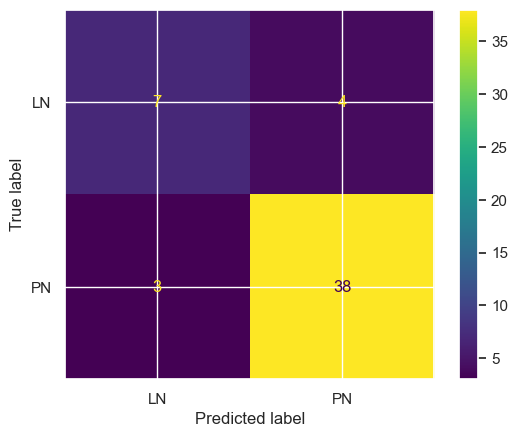

f1 score: 0.9156626506024096
balanced accuracy score: 0.7815964523281597


In [12]:
# def tunaClassifier(XTrain,yTrain,NFold,scalerFunc,estimatorFunc,params):
#     #create a pipeline composed of a minmaxscaler and then estimatorFunc
#     pipe = Pipeline([('scaler',scalerFunc),('estimator',estimatorFunc)])
#     #grid search cv
#     grid_search_cv = GridSearchCV(pipe,params,cv=StratifiedKFold(n_splits=NFold,shuffle = True, random_state=42),\
#                                   scoring='f1',refit='f1',verbose=5,n_jobs=1).fit(XTrain,yTrain)
    
#     #best estimator inside pipeline
#     lr_params = grid_search_cv.best_params_
#     lr_params = {key[11:]:value for key,value in lr_params.items()}
    


#     lr = grid_search_cv.best_estimator_
#     lr_pred = cross_val_predict(lr,XTrain,yTrain,cv= StratifiedKFold(n_splits=NFold,shuffle=True,random_state=42))

#     #display best params
#     print(f"best params: {grid_search_cv.best_params_}")

#     return lr_params,lr_pred



# #use logistic regression to train on ts_df
# ts_X = ts_df_pruned[pruned_nine_cols[:-1]]
# ts_y = ts_df_pruned['label']
# # ts_X = ts_df[nine_cols]

# params = {'estimator__tol':[0.0001,0.001,0.01,0.1,1],\
#             'estimator__C':[0.01,0.1,1,10,100],\
#                 'estimator__solver':['newton-cg','lbfgs','liblinear','sag','saga'],\
#                     'estimator__penalty':['None','l1','l2','elasticnet']}



# lr_params,lr_pred = tunaClassifier(ts_X,ts_y,5,preprocessing.MinMaxScaler(),LogisticRegression(),params)

# #confusion matrix display
# cm = confusion_matrix(ts_y,lr_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['LN','PN'])
# disp.plot()
# plt.x_label = 'Predicted label'
# plt.y_label = 'True label'
# #save confusion matrix
# plt.savefig('lr_confusion_matrix.jpg',bbox_inches='tight',dpi=300)
# plt.show()


# #f1 score
# f1 = f1_score(ts_y,lr_pred)
# print(f"f1 score: {f1}")

# #balanced accuracy score
# balanced_accu = balanced_accuracy_score(ts_y,lr_pred)
# print(f"balanced accuracy score: {balanced_accu}")

unlabeled_pred_proba: [0.39296464 0.94348043 0.72198511 0.41349762 0.11104728 0.12306389
 0.22274172 0.63130593 0.26765449 0.08980487 0.83874933 0.67737657
 0.09513523 0.13741408 0.12398536 0.8951538  0.41980861 0.21902185
 0.94102714 0.63589557 0.27238203 0.26497688 0.08239032 0.78996844
 0.32186315 0.42282855 0.4851342  0.999768   0.15248378 0.86770493
 0.99959716 0.87415174 0.83297216 0.80251896 0.90117547 0.9760659
 0.99821965 0.87930417 0.1459401  0.97337677 0.94556431 0.62348946
 0.71896677 0.97864272 0.64533667 0.30860086 0.54659357 0.56248452
 0.64909648 0.37045707 0.59877571 0.32510524 0.92208669 0.48177835
 0.80413526 0.25624472 0.7125376  0.5698086  0.32665337 0.40829089
 0.44127195 0.97024038 0.29812267 0.54781945 0.35967933 0.22885122
 0.20379169 0.76364284 0.62587521 0.55653122 0.48814841 0.28241068
 0.36655613 0.91486064 0.83830943 0.83928363 0.96448418 0.53099145
 0.42209318 0.57563897 0.20121849 0.33165203 0.41052596 0.39072754
 0.987114   0.57913746]


array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1])

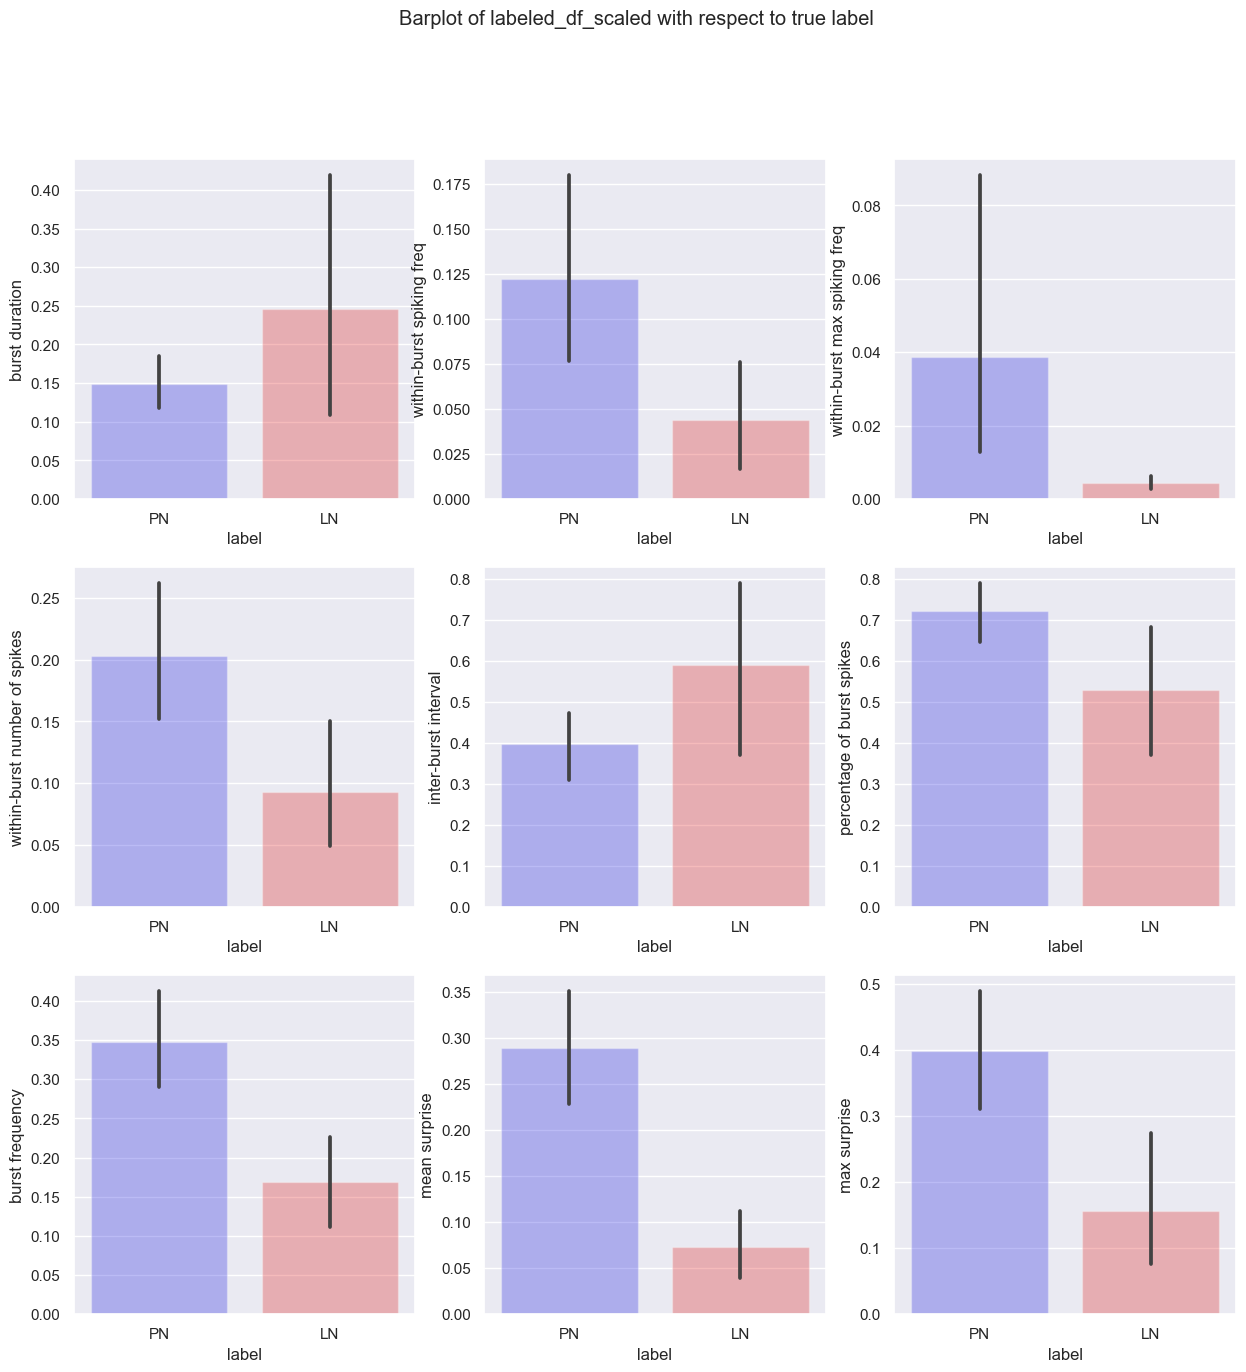

In [13]:
#Now, train lr on entire training set and test lr on unlabeled_df
ts_X_scaled = preprocessing.MinMaxScaler().fit_transform(ts_X)
lr = LogisticRegression(**lr_params)
lr.fit(ts_X_scaled,ts_y)

#prediction
unlabeled_df_pruned_scaled = preprocessing.MinMaxScaler().fit_transform(unlabeled_df_pruned)
unlabeled_pred = lr.predict(unlabeled_df_pruned_scaled)
unlabeled_pred_proba = lr.predict_proba(unlabeled_df_pruned_scaled)[:,-1]

# unlabeled_df_scaled = preprocessing.MinMaxScaler().fit_transform(unlabeled_df[nine_cols])
# unlabeled_pred = lr.predict(unlabeled_df_scaled)
# unlabeled_pred_proba = lr.predict_proba(unlabeled_df_scaled)[:,-1]

print(f"unlabeled_pred_proba: {unlabeled_pred_proba}")
unlabeled_df_with_pred = copy.deepcopy(unlabeled_df)
unlabeled_df_with_pred['label'] = unlabeled_pred
#replace 0 with LN and 1 with PN
unlabeled_df_with_pred['label'] = unlabeled_df_with_pred['label'].replace({0:'LN',1:'PN'})
display(unlabeled_pred)

#barplot of ts_df
#replace PN with 1 and LN with 0
#minmax scale the 9 parameters of ts_df
ts_df_scaled = preprocessing.MinMaxScaler().fit_transform(ts_df[nine_cols])
ts_df_scaled = pd.DataFrame(ts_df_scaled,columns=nine_cols)
ts_df['label'] = ts_df['label'].replace({0:'LN',1:'PN'})
ts_df_scaled['label'] = ts_df['label']
histoResults(ts_df_scaled,nine_cols,sns.barplot,{'x':'label','palette':['blue','red'],'order':['PN','LN']},\
             barplot = True,saveFileName = 'labeled_df_scaled_with_true_label.pdf',\
                figsize=(50,50),main_title='Barplot of labeled_df_scaled with respect to true label')

Tree-Based Method

Save Data as Json

In [14]:
display(unlabeled_df_with_pred)
#save unlabeled_df_with_pred to csv
unlabeled_df_with_pred.to_csv('unlabeled_df_with_pred_nine_params.csv',index=False)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Neuron,Stimuli,label
0,1.4453,13.837958,21.568325,20,1.1147,0.909091,0.100985,8.129553,13.005666,070906,S1U1,Lin,LN
1,1.7999,20.556698,20.556698,37,0.0000,0.860465,0.050833,22.067839,22.067839,070906,S2U1,Lin,PN
2,3.7055,10.524895,10.524895,39,0.0000,1.000000,0.050041,15.146894,15.146894,070906,S2U4,Lin,PN
3,3.0363,4.281527,93.750000,13,0.0428,1.000000,0.154292,6.023302,7.575765,070906,S2U5,Lin,LN
4,1.3912,2.875216,2.875216,4,0.0000,0.800000,0.050921,2.753871,2.753871,070906,S3U1,Lin,LN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,13.4148,2.907237,15.313936,39,3.0775,0.750000,0.200954,4.030531,8.179410,071002,S1U1_selectiveunit,Myr,LN
82,2.6058,8.826464,70.422535,23,15.0734,0.460000,0.255294,2.609333,3.521100,071002,S1U2,Myr,LN
83,4.4924,11.129908,20.990764,50,12.9673,0.769231,0.250262,3.750014,9.769924,071002,S1U3,Myr,LN
84,2.6336,102.521264,233.918129,270,15.3836,0.437601,0.950062,3.861261,18.424534,071002,S1U4,Myr,PN


86

accuracy: 0.6451612903225806


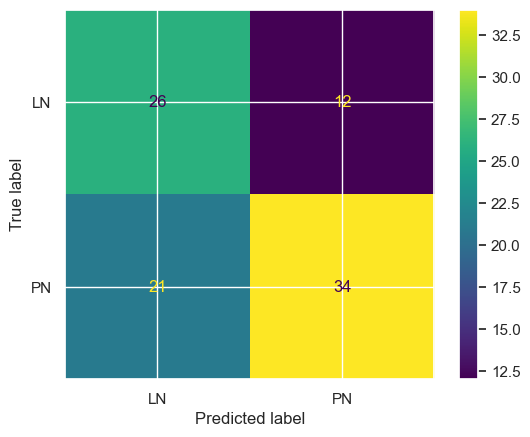

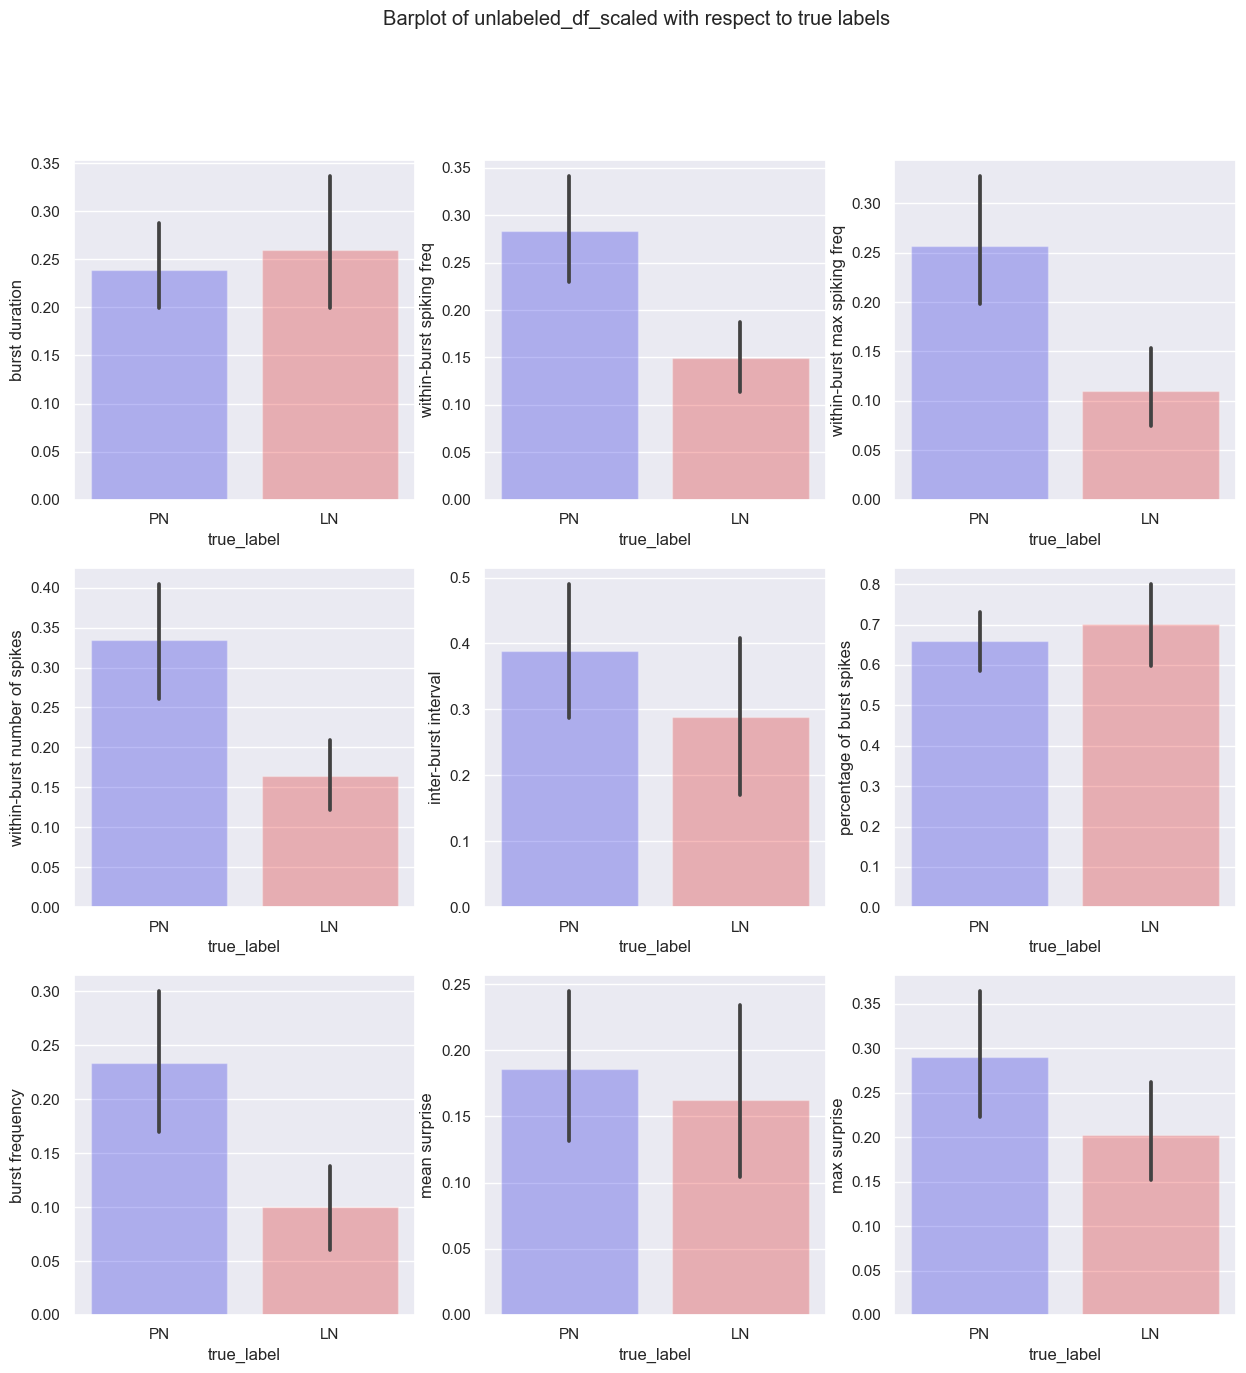

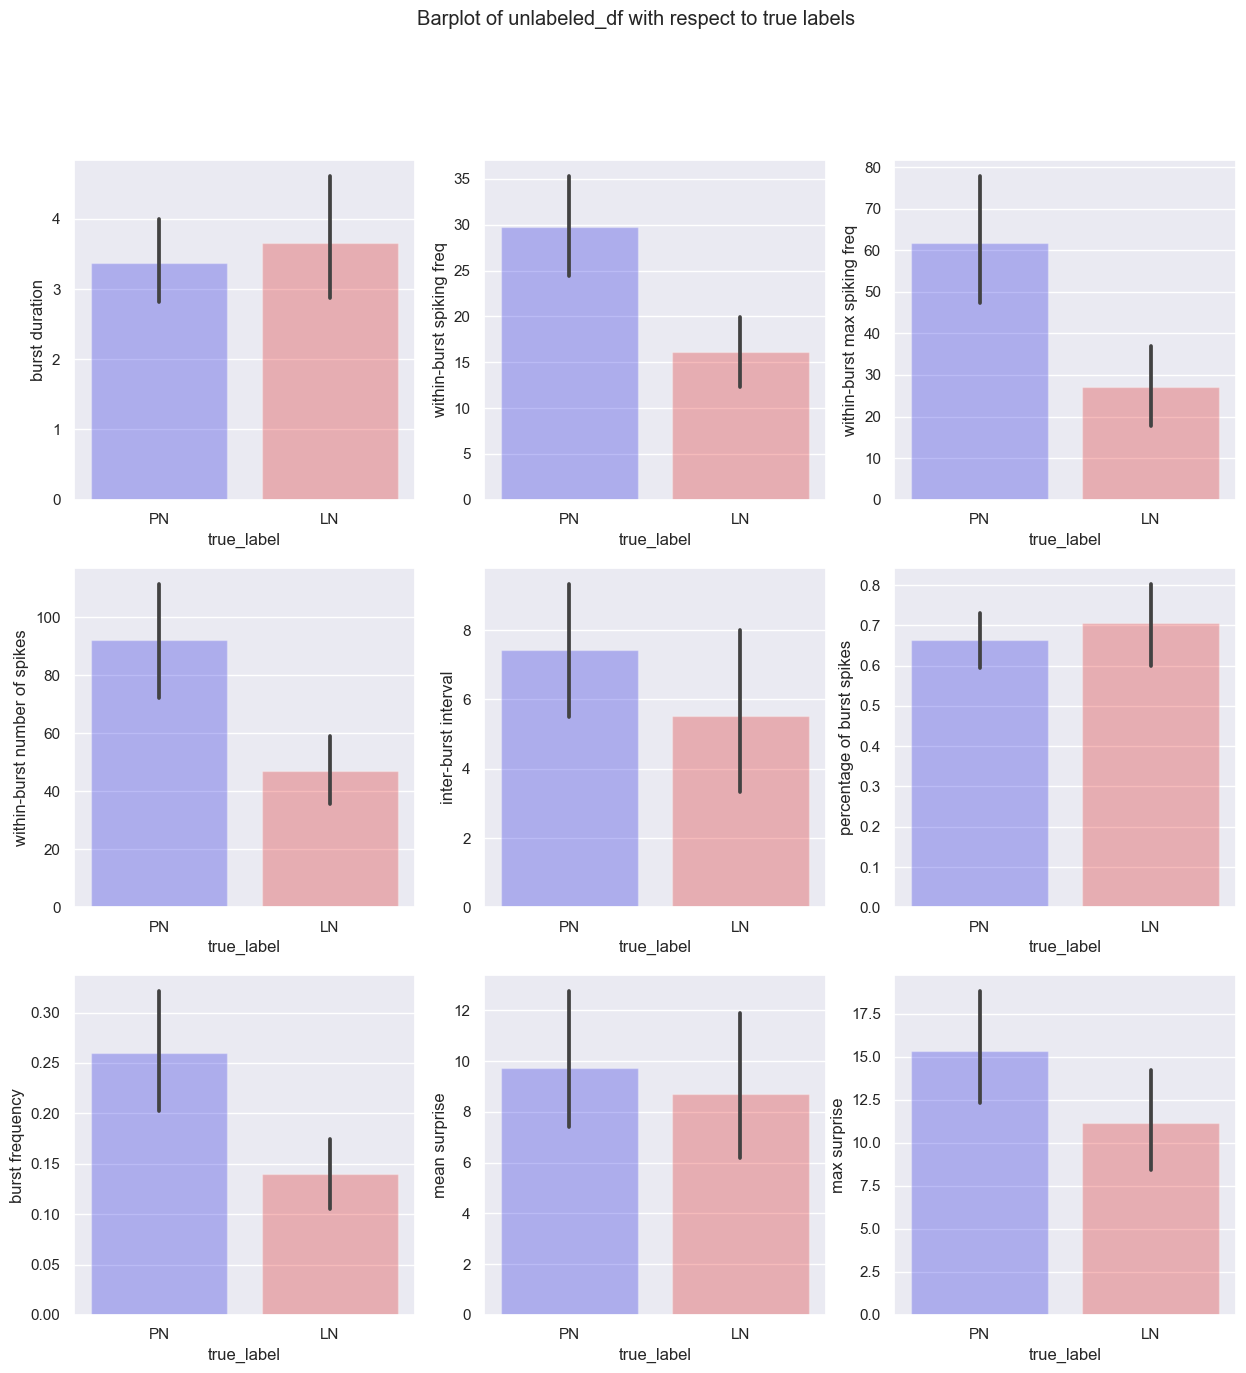

In [15]:
def get_label_from_true_json(data,name_base,neuron_base,true_json_data):
    true_label = []

    for i,label in enumerate(data):
        true_label.append(true_json_data[name_base[i]][neuron_base[i]]['true'])


    return true_label

true_json_data = json.load(open('unlabeled_pred.json'))
true_labels = get_label_from_true_json(unlabeled_pred,unlabeled_nameRes,unlabeled_neuronRes,true_json_data)
display(len(true_labels))
#add true_labels as a new column to unlabeled_df_with_pred
unlabeled_df_with_pred['true_label'] = true_labels

true_labels_no_burst = get_label_from_true_json(unlabeled_no_burst_nameRes,unlabeled_no_burst_nameRes,unlabeled_no_burst_neuronRes,true_json_data)
true_labels_extended = true_labels + true_labels_no_burst
#append LNs after predicted labels
unlabeled_pred_extended = list(unlabeled_df_with_pred['label']) + ['LN']*len(unlabeled_no_burst_nameRes)

#compute and display accuracy
accu = accuracy_score(true_labels_extended,unlabeled_pred_extended)
print(f"accuracy: {accu}")

#confusion matrix display
cm = confusion_matrix(true_labels_extended,unlabeled_pred_extended)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['LN','PN'])
disp.plot()
plt.x_label = 'Predicted label'
plt.y_label = 'True label'
#save confusion matrix
plt.savefig('unlabeled_lr_confusion_matrix_March.jpeg',bbox_inches='tight',dpi=300)


#read label and true_label columns of unlabeled_df_with_pred
unlabeled_scaler = preprocessing.MinMaxScaler()
unlabeled_df_scaled = unlabeled_scaler.fit_transform(unlabeled_df[nine_cols])
unlabeled_df_scaled = pd.DataFrame(unlabeled_df_scaled,columns=nine_cols)
unlabeled_df_scaled['true_label'] = true_labels
histoResults(unlabeled_df_scaled,nine_cols,sns.barplot,{'x':'true_label','palette':['blue','red'],'order':['PN','LN']},\
             barplot = True,saveFileName = 'unlabeled_df_scaled_true.pdf',\
                figsize=(50,50),main_title='Barplot of unlabeled_df_scaled with respect to true labels')

#barplot 
histoResults(unlabeled_df_with_pred,nine_cols,sns.barplot,{'x':'true_label','palette':['blue','red'],'order':['PN','LN']},\
             barplot = True,saveFileName = 'unlabeled_df_with_lr_pred_true.pdf',\
                figsize=(50,50),main_title='Barplot of unlabeled_df with respect to true labels')

In [16]:
def save_label_as_json(pred_data):

    #initialize json data
    json_data = {}

    for i,label in enumerate(pred_data):
        if label == 0:
            l = 'LN'
        else:
            l = 'PN'

        #set json data
        if unlabeled_nameRes[i] not in json_data:
            json_data[unlabeled_nameRes[i]] = {}

        # json_data[unlabeled_nameRes[i]][unlabeled_neuronRes[i]] = {'label':l,'stimuli':unlabeled_stimuliRes[i],\
        #     'within-burst max spiking freq':unlabeled_df['within-burst max spiking freq'][i],\
        #     'within-burst number of spikes':unlabeled_df['within-burst number of spikes'][i],\
        #     'percentage of burst spikes':unlabeled_df['percentage of burst spikes'][i],\
        #     'burst frequency':unlabeled_df['burst frequency'][i],\
        #     'mean surprise':unlabeled_df['mean surprise'][i],\
        #     'max surprise':unlabeled_df['max surprise'][i]}
        

        json_data[unlabeled_nameRes[i]][unlabeled_neuronRes[i]] = {'label':l,'stimuli':unlabeled_stimuliRes[i]}


    for i in range(len(unlabeled_no_burst_nameRes)):
        #set json data
        if unlabeled_no_burst_nameRes[i] not in json_data:
            json_data[unlabeled_no_burst_nameRes[i]] = {}

        json_data[unlabeled_no_burst_nameRes[i]][unlabeled_no_burst_neuronRes[i]] = {'label':'unknown','stimuli':unlabeled_no_burst_stimuliRes[i]}


    #save json data
    with open('unlabeled_pred_Feb.json','w') as f:
        json.dump(json_data,f)

    display(json_data)

    return json_data

# json_data = save_label_as_json(unlabeled_pred)

Spike Plotting (Bea, Ctl, totalDf)

In [17]:
def load_range_data(mothName,neuronName):
    #initialize dataframe
    two_seconds_df = pd.DataFrame(columns=['timestamp_start','timestamp_end','stimuli'])

    #confirm time range from timestamps csv 
    timestamps_csv_filename = f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothName}.csv'
    timestamp_csv = pd.read_csv(timestamps_csv_filename,header=0)
    for stimulus in timestamp_csv.columns:
        if stimulus[0] != 'P' and stimulus[0] != 'M':


            timestamp_onset = timestamp_csv.iloc[0][stimulus]
            timestamp_end = timestamp_onset + 2
            #2 seconds before stimulus
            timestamp_start = timestamp_end - 2.5


            #load data from _prep.mat file
            prep_filename = f'../ALdata/{mothName}_prep.mat'
            prep = loadmat(prep_filename)
            prep_timestamps = list(i[0] for i in prep[neuronName])
            #crop the part of prep_timestamps where the time is larger than timestamp_start and smaller than timestamp_end
            cropped_prep_timestamps = [i for i in prep_timestamps if i >= timestamp_start and i <= timestamp_end]

            two_seconds_df = two_seconds_df.append({'timestamp_start':timestamp_start,\
                                                    'timestamp_end':timestamp_end,\
                                                    'timestamp_onset':timestamp_onset,\
                                                    'timestamps': cropped_prep_timestamps,\
                                                        'stimuli':stimulus},ignore_index=True)


    return two_seconds_df


def y_spikes(x_start,x_end,timestamps):
    x_bot = np.linspace(x_start,x_end,200000)

    y = []
    for x in x_bot:
        x = round(x,4)
        if x in timestamps:
            y.append(1)
        else:
            y.append(0)

    return x_bot,y

def plot_spike(index):

    loaded_range_data = load_range_data(totalName[index],totalNeuron[index])
    loaded_range_data_shape = loaded_range_data.shape[0]
    fig,axs = plt.subplots(1 + loaded_range_data_shape,1,figsize = (10, 6*loaded_range_data_shape))

    mothName = totalName[index]
    neuronName = totalNeuron[index]
    pred_label = json_data[mothName][neuronName]['label']

    #totalDf
    x_bot,y = y_spikes(0,20,totalDf[index])
    axs[0].plot(x_bot,y)
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('spike')
    axs[0].set_title(f"spike train of unlabeled test data {mothName}_{neuronName}_{pred_label}_Spontaneous")

    for row_index in range(loaded_range_data_shape):
        x_bot,y = y_spikes(loaded_range_data['timestamp_start'][row_index],\
                           loaded_range_data['timestamp_end'][row_index],\
                               loaded_range_data['timestamps'][row_index])
        axs[row_index + 1].plot(x_bot,y)
        y_min = min(y)
        #plot a  vertical line at x coordinate timestamp_onset
        axs[row_index + 1].vlines(x=loaded_range_data['timestamp_onset'][row_index],ymin = 0, ymax = 0.3, color='red')
        axs[row_index + 1].set_xlabel('time')
        axs[row_index + 1].set_ylabel('spike')
        axs[row_index + 1].set_title(f"spike train of {loaded_range_data['stimuli'][row_index]} {mothName}_{neuronName}_{pred_label}_{loaded_range_data['stimuli'][row_index]}")

    # plt.show()
    fig.savefig(f"stimuli_unlabeled_data_spikes_plots_1_19/stimuli_unlabeled_data_spikes_1_19_{mothName}_{neuronName}_{pred_label}.pdf")

    return

# for i in list(range(len(totalDf))):
#     print(i)
#     plot_spike(i)